# Hartford, CT Regional Area Travel Demand Model
Albab Noor, Adrita Islam, & Raymond Gerte

CE 5730: Transportation Planning


## Introduction

Some of the most important tools that transportation planners have at their disposal are transportation models. Whether based on a disaggregate activity-based framework or a more traditional 4-step aggregate approach, all models attempt to make some assumptions and simplification of real world systems in order to formulate mathematical representations of everyday phenomena.  

In the following notebook, we have adopted the classical 4-step approach to help us quantify and understand the demand in the Local Hartford Metropolitan Area. In line with the scope of this project, only the first 3 steps have been generated. This includes Trip Generation, Trip Distribution, and Mode Choice. The final step, Traffic Assignment, was left aside for future work.

## Trip Generation (Albab Noor)

#### Introduction

Trip Generation is the first step of the traditional four-step travel demand model. In this step, the modeler estimates the number of trips generated in each zone (unit of analysis). This is done in 2 steps, (i) Trip Productions - where the modeler estimates how many trips are produced in each zone, and (ii) Trip Attractions - where the modeler estimates how many trips are attracted by each zone. At the end of this step, the modeler will have the total number of trips produced and attracted for every zone in the region.

#### Methodology

A linear regression model is estimated for the trip production part of the process. The model was estimated using the Connecticut Household Travel Survey data. The variables available in the land use file dictated the variables that could be used in the model. Trip attraction was assumed to be a function of employment in the particular zone. Higher the employment, larger is the trip attraction and vice versa.

### Import Libraries

In [176]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from scipy import ndimage
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from collections import OrderedDict
from patsy import dmatrices
import pylogit as pl

import warnings 
warnings.filterwarnings('ignore')

"import geopandas as gpd\nfrom geopandas import GeoDataFrame\nfrom shapely.geometry import Point\nfrom scipy import ndimage\nimport matplotlib.pylab as pylab\nimport matplotlib.pyplot as plt\nimport scipy.stats as stats\nimport statsmodels.api as sm\nfrom collections import OrderedDict\nfrom patsy import dmatrices\nimport pylogit as pl\n\nimport warnings \nwarnings.filterwarnings('ignore')"

In [177]:
pd.options.display.max_columns = 180

### Load Data

In [179]:
csts_data = pd.read_excel('./HH_11_18_2016.xlsx') # Houshold File - CSTS Data
land_use = pd.read_csv('./sed_2010.csv') # Land Use Data
node = gpd.read_file('./node_network/Node.shp') #Network Nodes
hfd = gpd.read_file('./node_network/Hartford.shp') # Network
taz = gpd.read_file('./zone_shapefile/Zone.shp') # Hartford TAZ

"node = gpd.read_file('./node_network/Node.shp') #Network Nodes\nhfd = gpd.read_file('./node_network/Hartford.shp') # Network\ntaz = gpd.read_file('./zone_shapefile/Zone.shp') # Hartford TAZ"

### Travel Time Skims

In [180]:
sov = pd.read_table('./skim_tables/Highway Skim SOV.txt', sep = ',', header = None)
hov = pd.read_table('./skim_tables/Highway Skim HOV.txt', sep = ',', header = None)
wbwb = pd.read_table('./skim_tables/Transit WBWB paths skim Table.txt', sep = ',', header = None)

#### Naming the Columns

In [181]:
sov.columns = ['origin', 'destination', 'sov_time', 'sov_distance']
hov.columns = ['origin', 'destination', 'hov_time', 'hov_distance']
wbwb.columns = ['origin', 'destination', 'generalized_cost', 'fare', 'ivtt', 'initial_wait_time', 'transfer_wait_time', 'transfer_walk_time', 'access_walk_time', 'egress_walk_time', 'number_of_transfers', 'ivtt_distance', 'mode_5_ivtt', 'total_walk_time', 'total_transit_time']

In [182]:
land_use[:2]

,Unnamed: 0,ZONE,HH0CARINC1,HH0CARINC2,HH0CARINC3,HH0CARINC4,HH1CARINC1,HH1CARINC2,HH1CARINC3,HH1CARINC4,HH1CARINC5,HH1CARINC6,HH2CARINC1,HH2CARINC2,HH2CARINC3,HH2CARINC4,HH2CARINC5,HH2CARINC6,HH2CARINC7,POPULATION,HOUSEHOLD,EMPLOYMENT,RET_EMP,NR_EMP,SHOPAREA,EXTCOUNTS,BIA_ZONAL,BIA_AIRPORT,DISTRICT,C0HWA_SHARE,HBWP_IX_R,HBWA_XI_R,HBOP_IX_R,HBOA_XI_R,NHBP_IX_R,NHBA_XI_R,TRKP_IX_R,TRKA_XI_R,AREA,Buf_Z_St,AREA_IND,Zone_Name
0,0,2,7.477427,4.673743,5.608304,23.364975,26.168660,5.608304,7.477427,5.608304,22.430413,67.289371,0.000935,0.000935,0.000935,0.000935,3.739181,16.823044,146.727108,609,343.000001,348,10.000000,338.0,0.001,0.001,2.001,0.001,2.001,0.018,0.029,0.044,0.017,0.026,0.016,0.017,0.022,0.024,NaN,NaN,Non_HFD,NaN
1,1,7,8.434286,0.937143,3.748571,10.308571,11.245714,0.000000,0.937143,3.748571,0.937143,20.617143,1.874286,1.874286,0.000000,0.000000,0.937143,14.057143,84.342857,346,164.000000,381,18.241362,363.0,0.000,0.000,2.000,0.000,2.000,0.018,0.029,0.044,0.017,0.026,0.016,0.017,0.022,0.024,NaN,NaN,Non_HFD,NaN


### Plot the Shapefiles

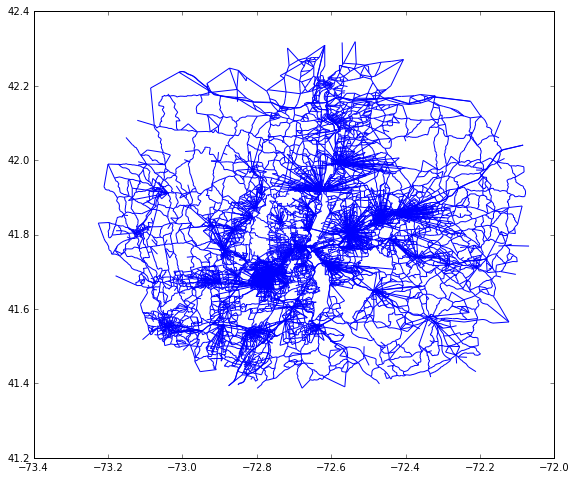

In [7]:
hfd.plot(figsize=(12, 8));

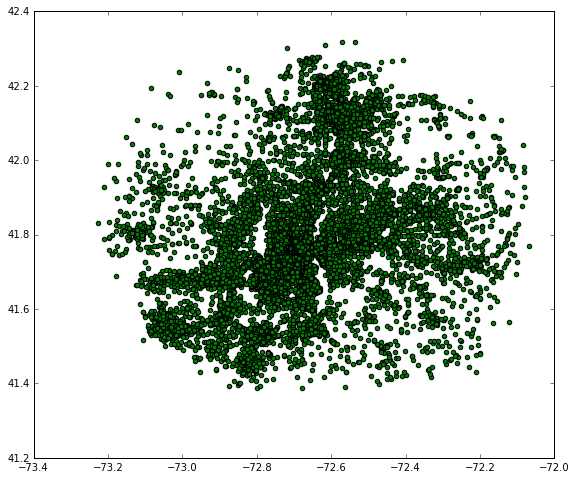

In [8]:
node.plot(color='green', edgecolor='black', figsize=(12, 8));

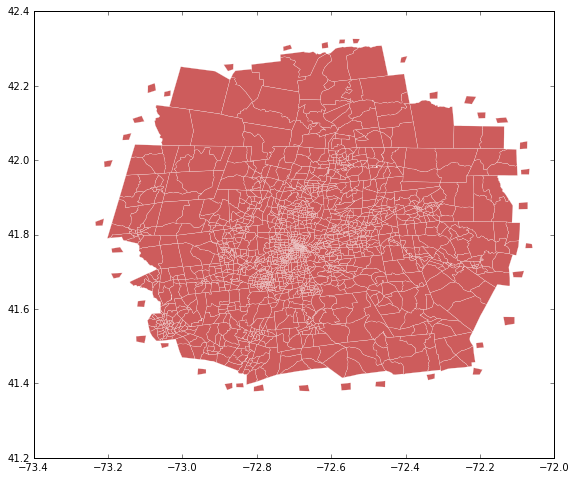

In [9]:
taz.plot(color='indianred', edgecolor='white', linewidth=.2, figsize=(12, 8));

In [10]:
taz.head()

,ID,AREA,TAZ,TOWN,STATE,ID_1,AREA_1,TAZ_1,TOWN_1,STATE_1,New_TAZ,geometry
0,1,8.27,8209,Winchester,CT,1,8.27,8209,Winchester,CT,1538,"POLYGON ((-73.168306 41.902135, -73.165196 41...."
1,2,10.68,8415,Ashford,CT,2,10.68,8415,Ashford,CT,1743,"POLYGON ((-72.151522 41.959302, -72.151645 41...."
2,3,7.08,8210,Winchester,CT,3,7.08,8210,Winchester,CT,1539,"POLYGON ((-73.12399599999999 41.913628, -73.12..."
3,4,2.89,8212,Winchester,CT,4,2.89,8212,Winchester,CT,1541,"POLYGON ((-73.06343 41.958355, -73.06389 41.95..."
4,5,7.17,8218,Barkhamstead,CT,5,7.17,8218,Barkhamstead,CT,1547,"POLYGON ((-73.04786 41.90963, -73.047838 41.90..."


In [11]:
taz['STATE'].value_counts()

CT    1721
MA      63
Name: STATE, dtype: int64

### Check Maps' Coordinate Reference System (CRS)

In [7]:
taz.crs, hfd.crs, node.crs

({}, {}, {})

#### Setting WGS84 as the CRS

In [8]:
taz.crs = {'init' :'epsg:4326'}
hfd.crs = {'init' :'epsg:4326'}
node.crs = {'init' :'epsg:4326'}

In [9]:
taz.crs, hfd.crs, node.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'}, {'init': 'epsg:4326'})

### Removing External Zones and Zones in Massachusetts

In [10]:
taz = taz[taz['TAZ'] < 9000] # Removing External Zones
taz = taz[taz['STATE'] != 'MA'] # Removing Massachusetts TAZ

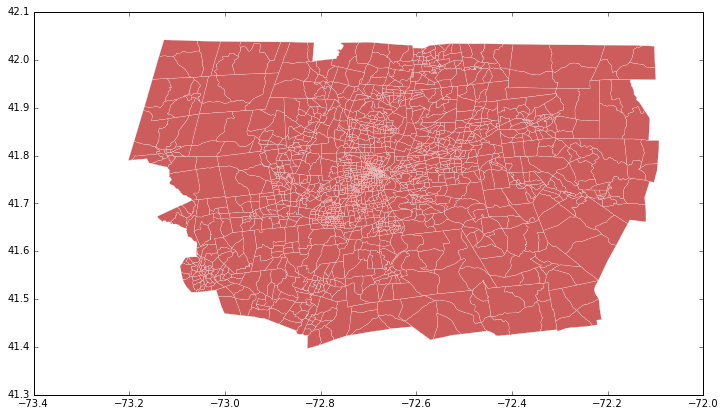

In [11]:
taz.plot(color='indianred', edgecolor='white', linewidth=.2, figsize=(12, 8));

In [17]:
taz['TAZ'].nunique()

1699

In [18]:
taz.head()

,ID,AREA,TAZ,TOWN,STATE,ID_1,AREA_1,TAZ_1,TOWN_1,STATE_1,New_TAZ,geometry
0,1,8.27,8209,Winchester,CT,1,8.27,8209,Winchester,CT,1538,"POLYGON ((-73.168306 41.902135, -73.165196 41...."
1,2,10.68,8415,Ashford,CT,2,10.68,8415,Ashford,CT,1743,"POLYGON ((-72.151522 41.959302, -72.151645 41...."
2,3,7.08,8210,Winchester,CT,3,7.08,8210,Winchester,CT,1539,"POLYGON ((-73.12399599999999 41.913628, -73.12..."
3,4,2.89,8212,Winchester,CT,4,2.89,8212,Winchester,CT,1541,"POLYGON ((-73.06343 41.958355, -73.06389 41.95..."
4,5,7.17,8218,Barkhamstead,CT,5,7.17,8218,Barkhamstead,CT,1547,"POLYGON ((-73.04786 41.90963, -73.047838 41.90..."


### Plot HH Locations on the Map

In [19]:
csts_data[:2]

,hhid,segnum,week,traveldate,hh_hts_status,hh_tripcount,hh_tripcount_20plus,transithh,recruit_start_et,recruit_end_et,recruit_duration,numvehicle,numvehicle_3plus,numbicycle,hhsize,hhsize_5plus,numadults,numstudents,numstudents_adult,numstudents_kid,numkids,numkids_3plus,numworkers,numworkers_3plus,numdrivers,rent_own,res_type,home_address,home_lat,home_lng,home_county,home_town,home_bg_geoid,hhincome_detailed,hhincome_followup,hhincome_broad,participate,callcenter_end,recruit_nonenglish,expansion_weight,final_weights,imputed_income_for_missing,imputed_hhincome_detailed,r_numvehicles_4plus,r_household_income_rev_2,r_numworkers_3plus,r_numpersons_6plus,r_household_type,r_presence_of_children,sample_geo,hh_tripcount_recode,hh_tripcount_20plus_recode
0,16100054,6,5,2016-04-21,1,5,5,0,2016-04-13 11:29:00,2016-04-13 11:36:00,7,2,2,0,2,2,2,0,0,0,0,0,0,0,2,1,1,"40 Jillian Cir, West Hartford, CT 06107, USA",41.746562,-72.777117,Hartford County,West Hartford,90034966001,99,3,3,1,1,0,208.123930,124.747957,6,6,2,3,0,2,1,0,10,5,5
1,16100093,1,9,2016-05-18,1,3,3,0,2016-05-22 16:52:00,2016-05-22 17:05:00,13,2,2,2,3,3,3,0,0,0,0,0,0,0,1,1,3,"119 Cedar St, New Haven, CT 06519, USA",41.294890,-72.930900,New Haven County,New Haven,90091403001,4,-99,2,2,0,0,80.329024,273.042033,-99,4,2,2,0,3,2,0,8,3,3


In [12]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(csts_data.home_lng, csts_data.home_lat)]
hh = GeoDataFrame(csts_data, crs=crs, geometry=geometry)
hh.head(2)

,hhid,segnum,week,traveldate,hh_hts_status,hh_tripcount,hh_tripcount_20plus,transithh,recruit_start_et,recruit_end_et,recruit_duration,numvehicle,numvehicle_3plus,numbicycle,hhsize,hhsize_5plus,numadults,numstudents,numstudents_adult,numstudents_kid,numkids,numkids_3plus,numworkers,numworkers_3plus,numdrivers,rent_own,res_type,home_address,home_lat,home_lng,home_county,home_town,home_bg_geoid,hhincome_detailed,hhincome_followup,hhincome_broad,participate,callcenter_end,recruit_nonenglish,expansion_weight,final_weights,imputed_income_for_missing,imputed_hhincome_detailed,r_numvehicles_4plus,r_household_income_rev_2,r_numworkers_3plus,r_numpersons_6plus,r_household_type,r_presence_of_children,sample_geo,hh_tripcount_recode,hh_tripcount_20plus_recode,geometry
0,16100054,6,5,2016-04-21,1,5,5,0,2016-04-13 11:29:00,2016-04-13 11:36:00,7,2,2,0,2,2,2,0,0,0,0,0,0,0,2,1,1,"40 Jillian Cir, West Hartford, CT 06107, USA",41.746562,-72.777117,Hartford County,West Hartford,90034966001,99,3,3,1,1,0,208.123930,124.747957,6,6,2,3,0,2,1,0,10,5,5,POINT (-72.77711740000001 41.74656230000001)
1,16100093,1,9,2016-05-18,1,3,3,0,2016-05-22 16:52:00,2016-05-22 17:05:00,13,2,2,2,3,3,3,0,0,0,0,0,0,0,1,1,3,"119 Cedar St, New Haven, CT 06519, USA",41.294890,-72.930900,New Haven County,New Haven,90091403001,4,-99,2,2,0,0,80.329024,273.042033,-99,4,2,2,0,3,2,0,8,3,3,POINT (-72.93090000000001 41.29489)


In [21]:
hh.crs

{'init': 'epsg:4326'}

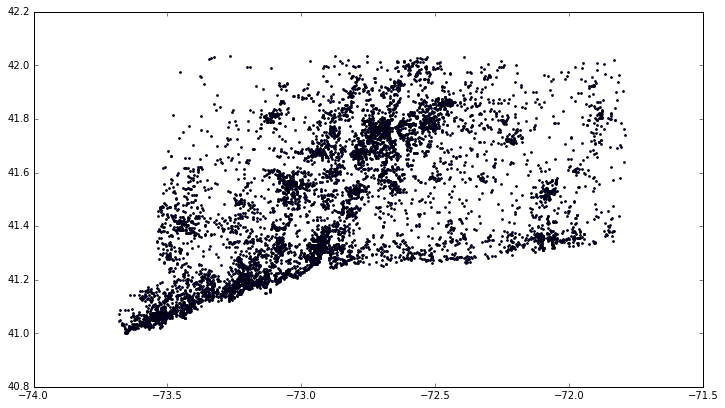

In [22]:
hh.plot(markersize=3, figsize=(12, 8));

### Select HHs within the Hartford TAZ

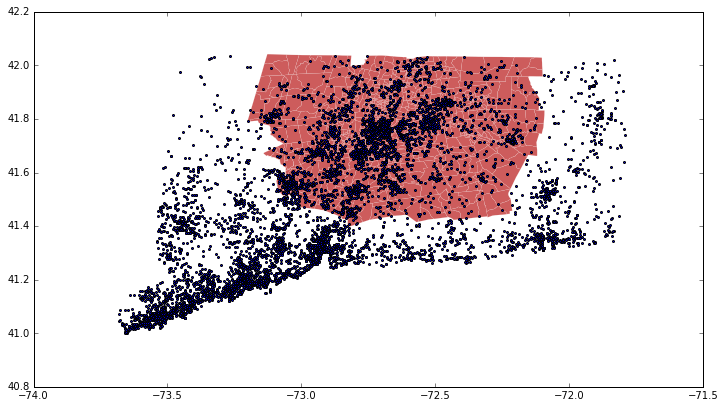

In [23]:
base = taz.plot(color='indianred', edgecolor='white', linewidth=.1, figsize=(12, 8))
hh.plot(ax=base, markersize=4, figsize=(12, 8));

#### Spatial Join to Identify Households within the CRCOG Region

In [13]:
hh_in_taz = gpd.sjoin(hh, taz, how = 'inner', op = 'intersects')

In [14]:
hh_in_taz.shape

(3524, 65)

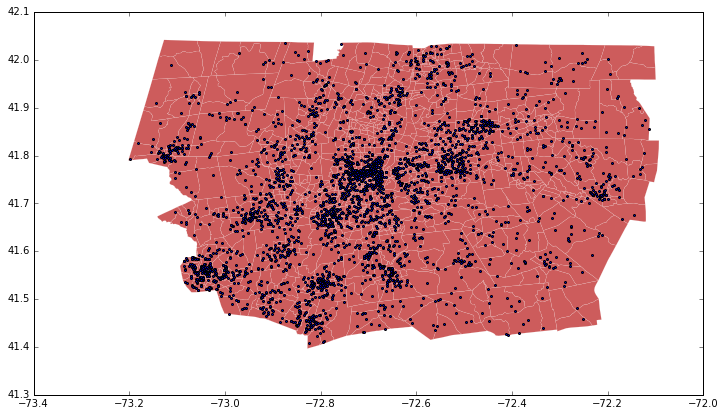

In [26]:
base = taz.plot(color='indianred', edgecolor='white', linewidth=.1, figsize=(12, 8))
hh_in_taz.plot(ax=base, markersize=4, figsize=(12, 8));

Geopandas Code Courtesy: Professor Paul Waddell, UC Berkeley (Urban Informatics & Visualization)

### Data Preparation for Model Estimation

#### Variables in CSTS Data

In [27]:
hh_in_taz.head(2)

,hhid,segnum,week,traveldate,hh_hts_status,hh_tripcount,hh_tripcount_20plus,transithh,recruit_start_et,recruit_end_et,recruit_duration,numvehicle,numvehicle_3plus,numbicycle,hhsize,hhsize_5plus,numadults,numstudents,numstudents_adult,numstudents_kid,numkids,numkids_3plus,numworkers,numworkers_3plus,numdrivers,rent_own,res_type,home_address,home_lat,home_lng,home_county,home_town,home_bg_geoid,hhincome_detailed,hhincome_followup,hhincome_broad,participate,callcenter_end,recruit_nonenglish,expansion_weight,final_weights,imputed_income_for_missing,imputed_hhincome_detailed,r_numvehicles_4plus,r_household_income_rev_2,r_numworkers_3plus,r_numpersons_6plus,r_household_type,r_presence_of_children,sample_geo,hh_tripcount_recode,hh_tripcount_20plus_recode,geometry,index_right,ID,AREA,TAZ,TOWN,STATE,ID_1,AREA_1,TAZ_1,TOWN_1,STATE_1,New_TAZ
0,16100054,6,5,2016-04-21,1,5,5,0,2016-04-13 11:29:00,2016-04-13 11:36:00,7,2,2,0,2,2,2,0,0,0,0,0,0,0,2,1,1,"40 Jillian Cir, West Hartford, CT 06107, USA",41.746562,-72.777117,Hartford County,West Hartford,90034966001,99,3,3,1,1,0,208.12393,124.747957,6,6,2,3,0,2,1,0,10,5,5,POINT (-72.77711740000001 41.74656230000001),673,639,0.7,46,West Hartford,CT,639,0.7,46,West Hartford,CT,36
502,16108561,6,2,2016-03-24,1,7,7,0,2016-03-19 08:02:00,2016-03-22 09:51:00,4429,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,"10 Royal Oak Dr, West Hartford, CT 06107, USA",41.739570,-72.774538,Hartford County,West Hartford,90034966001,99,99,99,1,0,0,208.12393,89.594968,8,8,1,4,1,1,3,0,10,7,7,POINT (-72.77453800000001 41.73957),673,639,0.7,46,West Hartford,CT,639,0.7,46,West Hartford,CT,36


#### Variables in Land Use Data

In [28]:
land_use.head()

,Unnamed: 0,ZONE,HH0CARINC1,HH0CARINC2,HH0CARINC3,HH0CARINC4,HH1CARINC1,HH1CARINC2,HH1CARINC3,HH1CARINC4,HH1CARINC5,HH1CARINC6,HH2CARINC1,HH2CARINC2,HH2CARINC3,HH2CARINC4,HH2CARINC5,HH2CARINC6,HH2CARINC7,POPULATION,HOUSEHOLD,EMPLOYMENT,RET_EMP,NR_EMP,SHOPAREA,EXTCOUNTS,BIA_ZONAL,BIA_AIRPORT,DISTRICT,C0HWA_SHARE,HBWP_IX_R,HBWA_XI_R,HBOP_IX_R,HBOA_XI_R,NHBP_IX_R,NHBA_XI_R,TRKP_IX_R,TRKA_XI_R,AREA,Buf_Z_St,AREA_IND,Zone_Name
0,0,2,7.477427,4.673743,5.608304,23.364975,26.168660,5.608304,7.477427,5.608304,22.430413,67.289371,0.000935,0.000935,0.000935,0.000935,3.739181,16.823044,146.727108,609,343.000001,348,10.000000,338.000000,0.001,0.001,2.001,0.001,2.001,0.018,0.029,0.044,0.017,0.026,0.016,0.017,0.022,0.024,NaN,NaN,Non_HFD,NaN
1,1,7,8.434286,0.937143,3.748571,10.308571,11.245714,0.000000,0.937143,3.748571,0.937143,20.617143,1.874286,1.874286,0.000000,0.000000,0.937143,14.057143,84.342857,346,164.000000,381,18.241362,363.000000,0.000,0.000,2.000,0.000,2.000,0.018,0.029,0.044,0.017,0.026,0.016,0.017,0.022,0.024,NaN,NaN,Non_HFD,NaN
2,2,9,5.454545,1.818182,0.000000,7.272727,1.818182,1.818182,0.000000,0.000000,5.454545,30.909091,0.000000,0.000000,0.000000,1.818182,1.818182,5.454545,56.363636,222,119.999999,858,45.000000,813.000000,0.000,0.000,4.000,0.000,3.000,0.018,0.030,0.041,0.011,0.013,0.008,0.009,0.011,0.013,NaN,NaN,Non_HFD,NaN
3,3,10,0.000000,0.000000,0.000000,5.471204,3.282723,1.094241,1.094241,2.188482,5.471204,56.900524,3.282723,1.094241,1.094241,0.000000,1.094241,9.848168,117.083770,573,209.000003,16,0.000000,16.333333,0.000,0.000,3.000,0.000,3.000,0.013,0.030,0.041,0.011,0.013,0.008,0.009,0.011,0.013,NaN,NaN,Non_HFD,NaN
4,4,11,0.000000,0.000000,3.517699,0.000000,7.035398,1.172566,7.035398,3.517699,1.172566,32.831858,3.517699,3.517699,0.000000,0.000000,5.862832,24.623894,171.194690,729,264.999998,332,1.767955,330.000000,0.000,0.000,6.000,0.000,4.000,0.013,0.030,0.041,0.011,0.013,0.008,0.009,0.011,0.013,NaN,NaN,Non_HFD,NaN


### Create NumVehicle and Income Categories to match the Land Use Data

In [15]:
hh_in_taz['numvehicle'].value_counts()

1    1319
2    1310
3     419
0     291
4     140
5      32
6       7
7       3
8       2
9       1
Name: numvehicle, dtype: int64

In [16]:
hh_in_taz['vehicle_0'] = (hh_in_taz['numvehicle'] == 0).astype(int)
hh_in_taz['vehicle_1'] = (hh_in_taz['numvehicle'] == 1).astype(int)
hh_in_taz['vehicle_2'] = (hh_in_taz['numvehicle'] >= 2).astype(int)

In [17]:
hh_in_taz['income_1'] = (hh_in_taz['imputed_hhincome_detailed'].isin([1,2])).astype(int)
hh_in_taz['income_2'] = (hh_in_taz['imputed_hhincome_detailed'].isin([3,4])).astype(int)
hh_in_taz['income_3'] = (hh_in_taz['imputed_hhincome_detailed'].isin([5,6])).astype(int)
hh_in_taz['income_4'] = (hh_in_taz['imputed_hhincome_detailed'].isin([7])).astype(int)
hh_in_taz['income_5'] = (hh_in_taz['imputed_hhincome_detailed'].isin([8])).astype(int)
hh_in_taz['income_6'] = (hh_in_taz['imputed_hhincome_detailed'].isin([9])).astype(int)
hh_in_taz['income_7'] = (hh_in_taz['imputed_hhincome_detailed'].isin([10,11,12])).astype(int)

### Linear Regression Model

$$ Y_{HH} = Intercept + (B_{hhsize}*HHSize) + (B_{vehicle_2:income_4}*vehicle_2:income_4) + (B_{vehicle_2:income_6}*vehicle_2:income_6) + (B_{vehicle_2:income_7}*vehicle_2:income_7) $$

In [18]:
y, X = dmatrices('hh_tripcount ~ hhsize + vehicle_2:income_4 + vehicle_2:income_6 + vehicle_2:income_7', data = hh_in_taz, return_type = 'dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           hh_tripcount   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     509.3
Date:                Tue, 12 Dec 2017   Prob (F-statistic):               0.00
Time:                        14:31:05   Log-Likelihood:                -10467.
No. Observations:                3524   AIC:                         2.094e+04
Df Residuals:                    3519   BIC:                         2.097e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.2135      0.167      7.268      0.000       0.886       1.541
hhsize                 3.0505      0.075     40.437      0.000       2.903       3.198
vehicle_2:income_4     0.7553      0.342      2.206      0.027       0.084       1.427
vehicle_2:income_6     0.9007      0.232      3.877      0.000       0.445       1.356
vehicle_2:income_7     0.8011      0.259      3.096      0.002       0.294       1.308
==============================================================================
Omnibus:                      772.647   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3010.505
Skew:                           1.037   Prob(JB):                         0.00
Kurtosis:                       7.025   Cond. No.                         11.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The variables in the final specification are the ones that are significant. Moreover, all variables are dummy variables except household size. The dummy variables were created to match land use data.

In [19]:
coefficients = res.params.tolist()

In [20]:
coefficients

[1.213504132539753,
 3.050460600647889,
 0.7552943294105583,
 0.9007482878469112,
 0.8011095329576525]

In [21]:
land_use[:2]

,Unnamed: 0,ZONE,HH0CARINC1,HH0CARINC2,HH0CARINC3,HH0CARINC4,HH1CARINC1,HH1CARINC2,HH1CARINC3,HH1CARINC4,HH1CARINC5,HH1CARINC6,HH2CARINC1,HH2CARINC2,HH2CARINC3,HH2CARINC4,HH2CARINC5,HH2CARINC6,HH2CARINC7,POPULATION,HOUSEHOLD,EMPLOYMENT,RET_EMP,NR_EMP,SHOPAREA,EXTCOUNTS,BIA_ZONAL,BIA_AIRPORT,DISTRICT,C0HWA_SHARE,HBWP_IX_R,HBWA_XI_R,HBOP_IX_R,HBOA_XI_R,NHBP_IX_R,NHBA_XI_R,TRKP_IX_R,TRKA_XI_R,AREA,Buf_Z_St,AREA_IND,Zone_Name
0,0,2,7.477427,4.673743,5.608304,23.364975,26.168660,5.608304,7.477427,5.608304,22.430413,67.289371,0.000935,0.000935,0.000935,0.000935,3.739181,16.823044,146.727108,609,343.000001,348,10.000000,338.0,0.001,0.001,2.001,0.001,2.001,0.018,0.029,0.044,0.017,0.026,0.016,0.017,0.022,0.024,NaN,NaN,Non_HFD,NaN
1,1,7,8.434286,0.937143,3.748571,10.308571,11.245714,0.000000,0.937143,3.748571,0.937143,20.617143,1.874286,1.874286,0.000000,0.000000,0.937143,14.057143,84.342857,346,164.000000,381,18.241362,363.0,0.000,0.000,2.000,0.000,2.000,0.018,0.029,0.044,0.017,0.026,0.016,0.017,0.022,0.024,NaN,NaN,Non_HFD,NaN


In [22]:
land_use['HOUSEHOLD'].isnull().sum()

0

### Estimating Trip Generation in Hartford

#### Removing External Zones from Land Use File

In [23]:
land_use_valid = pd.merge(taz, land_use, left_on = 'TAZ', right_on = 'ZONE', how = 'left')

In [24]:
land_use_valid.shape

(1699, 54)

#### Filtering Land Use Data for Relevant Variables

In [25]:
zone_PA = land_use_valid[['ZONE', 'HH2CARINC4', 'HH2CARINC6', 'HH2CARINC7', 'POPULATION', 'EMPLOYMENT', 'HOUSEHOLD']]

In [26]:
zone_PA['HHSIZE'] = zone_PA['POPULATION']/zone_PA['HOUSEHOLD']

In [27]:
zone_PA.shape

(1699, 8)

### Estimating Trip Productions by Zone

In [28]:
zone_PA['TRIP_PRODUCTIONS'] = coefficients[0] + (zone_PA['HHSIZE'] * coefficients[1] * zone_PA['HOUSEHOLD']) + (zone_PA['HH2CARINC4'] * coefficients[2]) + (zone_PA['HH2CARINC6'] * coefficients[3]) + (zone_PA['HH2CARINC7'] * coefficients[4])

In [29]:
zone_PA['TRIP_PRODUCTIONS'].isnull().sum()

91

In [30]:
zone_PA.head()

,ZONE,HH2CARINC4,HH2CARINC6,HH2CARINC7,POPULATION,EMPLOYMENT,HOUSEHOLD,HHSIZE,TRIP_PRODUCTIONS
0,8209,1.971815,15.308456,64.424577,397,25,159.000000,2.496855,1279.135872
1,8415,0.000000,36.560330,193.819835,807,90,303.000000,2.663366,2651.137781
2,8210,6.312289,49.006313,206.239684,1275,490,509.000002,2.504912,4104.681336
3,8212,9.375423,72.787374,306.320631,1671,824,756.000000,2.210317,5416.573852
4,8218,4.868526,54.302788,211.219123,984,239,375.999999,2.617021,3224.666702


In [31]:
zone_PA['TRIP_PRODUCTIONS'].replace(to_replace = [np.inf, np.nan], value = 0, inplace = True)

In [32]:
zone_PA['TRIP_PRODUCTIONS'].isnull().sum()

0

In [33]:
zone_PA[:2]

,ZONE,HH2CARINC4,HH2CARINC6,HH2CARINC7,POPULATION,EMPLOYMENT,HOUSEHOLD,HHSIZE,TRIP_PRODUCTIONS
0,8209,1.971815,15.308456,64.424577,397,25,159.0,2.496855,1279.135872
1,8415,0.000000,36.560330,193.819835,807,90,303.0,2.663366,2651.137781


In [34]:
zone_PA['TRIP_PRODUCTIONS'].sum()

5066982.120891531

### Estimating Trip Attractions by Zone

Here, we consider that trip attraction is only a function of employment in a zone.

In [35]:
zone_PA['EMPLOYMENT'].sum()

713120

In [36]:
zone_PA['EMPLOYMENT_PERC'] = (zone_PA['EMPLOYMENT'])/(zone_PA['EMPLOYMENT'].sum())

In [37]:
zone_PA['EMPLOYMENT_PERC'].sum()

1.0

In [38]:
zone_PA['TRIP_ATTRACTIONS'] = (zone_PA['EMPLOYMENT_PERC']) * (zone_PA['TRIP_PRODUCTIONS'].sum())

In [39]:
zone_PA['HOUSEHOLD'].sum()

611567.00005199993

### Check: Match Total Productions and Total Attractions

In [40]:
zone_PA['TRIP_ATTRACTIONS'].sum(), zone_PA['TRIP_PRODUCTIONS'].sum()

(5066982.120891531, 5066982.120891531)

In [43]:
#zone_PA.to_excel('./zone_PA.xlsx')

In [44]:
zone_PA.shape

(1699, 11)

### Summary

The output of this step is the total trip productions and trip attractions by zone. This marks the end of the Trip Generation step. The limitations of this model is discussed at the end of all three steps.

## Trip Distribution (Adrita Islam)

Trip distribution is the third step of traditional four step travel demand modelling. After trip generation, a matrix consisting of trip production and attraction from all zones are produced. In trip distribution step, these attractions are matched with production and a trip interchange matrix is created. In other words, the trip distribution step gives us how many trips are going from zone we to all other zones. 


There are several different methods for calculating trip distribution. Gravity models, based on Newton's Gravitational Law are well accepted models for calculating trip interchanges. The model includes the following inputs and gives the following output.

Inputs

    - Productions and attractions
    - Deterrence function form, and parameter estimates
    - Cost matrix
    - K factors (optional)

Outputs

    - Trip matrix (and estimated trip lengths)
    
The general form of gravity model is:

$$ T_{ij} = \alpha P_{i} A_{j} f(c_{ij}) K_{ij} $$

Where,
    
   - $T_{ij}$ is the number of trip interchanges between production zone 𝑖 and attraction zone 𝑗
   - $\alpha$ is the proportionality constant
   - $P_{i}$ is the number of trip produced by production zone 𝑖
   - $A_{j}$ is the number of trip attracted by attraction zone 𝑗
   - $K_{ij}$ desirability of a trip between 𝑖𝑖and 𝑗 relative to other combinations of 𝑖 and 𝑗
   - $𝑓(𝑐_{𝑖j})$ is a generalized function of the travel costs with one or more parameters that need to be estimated

There are different kinds of gravity models. For this TDM model, a ***Singly Constraint Gravity Model*** was used. 

In [259]:
#zone_PA = pd.read_excel('./zone_PA.xlsx')

### Data Preparation

#### Filtering Skim Data to Match Land Use Data

In [260]:
sov.shape

(3207684, 4)

In [261]:
sov_filtered = pd.merge(sov, zone_PA, left_on = 'origin', right_on = 'ZONE', how = 'right')
sov_filtered_2 = pd.merge(sov_filtered, zone_PA, left_on = 'destination', right_on = 'ZONE', how = 'right')

In [262]:
sov_filtered_2.shape

(2869643, 26)

In [263]:
del sov_filtered

In [264]:
sov_filtered_2['origin'].nunique()

1695

In [265]:
sov_filtered_2.head()

,origin,destination,sov_time,sov_distance,ZONE_x,HH2CARINC4_x,HH2CARINC6_x,HH2CARINC7_x,POPULATION_x,EMPLOYMENT_x,HOUSEHOLD_x,HHSIZE_x,TRIP_PRODUCTIONS_x,EMPLOYMENT_PERC_x,TRIP_ATTRACTIONS_x,ZONE_y,HH2CARINC4_y,HH2CARINC6_y,HH2CARINC7_y,POPULATION_y,EMPLOYMENT_y,HOUSEHOLD_y,HHSIZE_y,TRIP_PRODUCTIONS_y,EMPLOYMENT_PERC_y,TRIP_ATTRACTIONS_y
0,2.0,2.0,0.40,NaN,2.0,0.000935,16.823044,146.727108,609.0,348.0,343.000001,1.775510,1991.642529,0.000488,2472.669085,2,0.000935,16.823044,146.727108,609,348,343.000001,1.77551,1991.642529,0.000488,2472.669085
1,9.0,2.0,10.50,6.11,9.0,1.818182,5.454545,56.363636,222.0,858.0,119.999999,1.850000,729.855638,0.001203,6096.408262,2,0.000935,16.823044,146.727108,609,348,343.000001,1.77551,1991.642529,0.000488,2472.669085
2,10.0,2.0,8.47,4.93,10.0,0.000000,9.848168,117.083770,573.0,16.0,209.000003,2.741627,1851.795073,0.000022,113.685935,2,0.000935,16.823044,146.727108,609,348,343.000001,1.77551,1991.642529,0.000488,2472.669085
3,11.0,2.0,7.33,4.33,11.0,0.000000,24.623894,171.194690,729.0,332.0,264.999998,2.750943,2384.324911,0.000466,2358.983150,2,0.000935,16.823044,146.727108,609,348,343.000001,1.77551,1991.642529,0.000488,2472.669085
4,12.0,2.0,8.03,4.65,12.0,0.000000,2.953846,141.784615,561.0,92.0,191.999999,2.921875,1828.767580,0.000129,653.694126,2,0.000935,16.823044,146.727108,609,348,343.000001,1.77551,1991.642529,0.000488,2472.669085


In [353]:
travel_time = sov_filtered_2[['origin', 'destination', 'sov_time', 'TRIP_PRODUCTIONS_x', 'TRIP_ATTRACTIONS_y']]
travel_time = travel_time.dropna()

In [354]:
travel_time = travel_time.sort_values(['origin', 'destination'], ascending = [1,1])

### Singly Constrained Model

For this TDM model, production values are modeled using CSTS survey data. Whereas attraction values are calculated from just using employment data. Since the production results are more trustworthy, a production constrained gravity model is used. Here, in order to meet the constraints, proportionality factor is replaced by balancing factors

$$ T_{ij} = B_{i} C_{j} P_{i} f(c_{ij}) K_{ij} $$

Where,
    
   - $B_{i}$ is the balancing factor for production zone 𝑖
   - $C_{i}$ is the balancing factor for attraction zone 𝑗

### Creating Deterrence Function 

An exponential deterrence Function was used for this model.   

$$ f(c_{i,j}) = exp({ - \beta * c_{i,j}}) $$ 

Where $ c_{i,j} $ is the cost function.

For this model, travel time by Single Occupancy Vehicles (sov_time) is used as the cost function and $\beta = 1$ is used. 

$$ f(c_{i,j}) = exp({ - 0.1 * sov-time}) $$

In [355]:
travel_time['detterence_func'] = np.exp(travel_time['sov_time']*-0.1)

In [356]:
travel_time.tail()

,origin,destination,sov_time,TRIP_PRODUCTIONS_x,TRIP_ATTRACTIONS_y,detterence_func
2862860,8419.0,8415.0,8.09,679.179129,639.483384,0.445303
2864554,8419.0,8416.0,0.96,679.179129,291.320208,0.908464
2866248,8419.0,8417.0,0.96,679.179129,447.638369,0.908464
2867942,8419.0,8418.0,6.39,679.179129,85.264451,0.527820
2869636,8419.0,8419.0,0.32,679.179129,85.264451,0.968507


### Applying Production Control Gravity Model

Assuming productions are correct, we calculate the trip interchanges by using the following steps.

   - Estimate the production balancing factors $𝐵_{𝑖} $
   $$ B_{i} = Σ_{j} C_{i} A_{j} f(c_{ij}) K_{ij} $$
   - Assume attraction balancing factors, $𝐶_{𝑗} = 1$
   - Assume attractiveness factor $K_{ij} =1 $ 

$$ T_{ij} = \frac {P_{i} A_{j} f(c_{ij}) K_{ij} } {Σ_{j} A_{j} f(c_{ij}) K_{ij}} $$

### Calculating Balancing Factor for Trip Interchange

In [357]:
travel_time['B_i'] = travel_time['TRIP_ATTRACTIONS_y'] * travel_time['detterence_func']

In [358]:
cols = travel_time.groupby(by = 'origin').sum()

In [359]:
cols = cols.reset_index()

In [360]:
cols = cols[['origin', 'B_i']]

In [361]:
travel_time = pd.merge(travel_time, cols, on= 'origin', how = 'left')

In [362]:
del travel_time['B_i_x']

In [363]:
travel_time.shape, cols.shape

((2869637, 7), (1695, 2))

In [364]:
travel_time.head()

,origin,destination,sov_time,TRIP_PRODUCTIONS_x,TRIP_ATTRACTIONS_y,detterence_func,denominator_y
0,2.0,2.0,0.40,1991.642529,2472.669085,0.960789,481719.322437
1,2.0,9.0,10.50,1991.642529,6096.408262,0.349938,481719.322437
2,2.0,10.0,8.47,1991.642529,113.685935,0.428699,481719.322437
3,2.0,11.0,7.32,1991.642529,2358.983150,0.480946,481719.322437
4,2.0,12.0,8.04,1991.642529,653.694126,0.447535,481719.322437


### Calculating Trip Interchanges

In [365]:
travel_time['TI_PA'] = np.round(travel_time['TRIP_PRODUCTIONS_x']*travel_time['TRIP_ATTRACTIONS_y']*travel_time['detterence_func']) / (travel_time['B_i_y'])

In [366]:
travel_time.head()

,origin,destination,sov_time,TRIP_PRODUCTIONS_x,TRIP_ATTRACTIONS_y,detterence_func,denominator_y,TI_PA
0,2.0,2.0,0.40,1991.642529,2472.669085,0.960789,481719.322437,9.822263
1,2.0,9.0,10.50,1991.642529,6096.408262,0.349938,481719.322437,8.820275
2,2.0,10.0,8.47,1991.642529,113.685935,0.428699,481719.322437,0.201501
3,2.0,11.0,7.32,1991.642529,2358.983150,0.480946,481719.322437,4.690711
4,2.0,12.0,8.04,1991.642529,653.694126,0.447535,481719.322437,1.209536


### Validity Check:
For a ***production control singly constraint gravity model***, the sum of trip interchange from each zone remains same as the sum of trip production from that zone after trip interchange step is complete. 

In [425]:
a = travel_time.groupby('origin').sum().reset_index()
a = a[['origin', 'TI_PA']]

In [426]:
b = travel_time.groupby(['origin', 'TRIP_PRODUCTIONS_x']).sum().reset_index()
b = b[['origin', 'TRIP_PRODUCTIONS_x']]

In [427]:
check = pd.merge(a, b, on= 'origin', how = 'left')

In [428]:
check

,origin,TI_PA,TRIP_PRODUCTIONS_x
0,2.0,1991.642553,1991.642529
1,9.0,729.855652,729.855638
2,10.0,1851.795068,1851.795073
3,11.0,2384.324879,2384.324911
4,12.0,1828.767575,1828.767580
5,13.0,3176.509395,3176.509404
6,14.0,2057.871652,2057.871633
7,15.0,3108.952062,3108.952145
8,16.0,3976.069722,3976.069764
9,17.0,3826.144964,3826.144964


In [400]:
check['TI_PA'].sum(), check['TRIP_PRODUCTIONS_x'].sum()

(5060012.647900039, 5060012.652961348)

### Adding Trip Lengths for Each P-A Pair

The output from Trip Interchange inclues trip lengths. In our model we have travel time as a measure of trip lengths.

In [402]:
travel_time_merged = pd.merge(travel_time, sov, left_on=['origin', 'destination'], right_on=['origin', 'destination'], how='left')
travel_time_merged1 = pd.merge(travel_time_merged, hov, left_on=['origin', 'destination'], right_on=['origin', 'destination'], how='left')
travel_time_merged2 = pd.merge(travel_time_merged1, wbwb, left_on=['origin', 'destination'], right_on=['origin', 'destination'], how='left')

### Convert from PA to OD

After the Trip Distribution step, trip interchanges are converted from Production-Attraction to Origin-Destination. 

- For NHB trips, $ OD_{ij}= PA_{ij} $
- For HB trips, $ OD_{ij}= 0.5 * PA_{ij} + 0.5 PA_{ji} $

As in our analysis, there is no notion of trip purpose, we use the second equation to calculate all OD trips. 

In [403]:
mirror_file = travel_time
mirror_file = mirror_file.sort_values(['destination', 'origin'], ascending = [1,1])

In [404]:
mirror_file = mirror_file.reset_index()
del mirror_file['index']

In [405]:
travel_time['TI_OD'] = (travel_time['TI_PA'] + mirror_file['TI_PA'])/2

In [413]:
travel_time.head()

,origin,destination,sov_time,TRIP_PRODUCTIONS_x,TRIP_ATTRACTIONS_y,detterence_func,denominator_y,TI_PA,TI_OD
0,2.0,2.0,0.40,1991.642529,2472.669085,0.960789,481719.322437,9.822263,9.822263
1,2.0,9.0,10.50,1991.642529,6096.408262,0.349938,481719.322437,8.820275,5.048578
2,2.0,10.0,8.47,1991.642529,113.685935,0.428699,481719.322437,0.201501,2.094540
3,2.0,11.0,7.32,1991.642529,2358.983150,0.480946,481719.322437,4.690711,5.513248
4,2.0,12.0,8.04,1991.642529,653.694126,0.447535,481719.322437,1.209536,3.501896


### Validity Check

OD Trip interchange should matche PA trip interchanges.

In [421]:
travel_time['TI_OD'].sum(), travel_time['TI_PA'].sum()

(5060012.647900403, 5060012.6479001995)

### Summary

In [422]:
counts1 = (travel_time['TI_PA']==travel_time['TI_PA'].min()).value_counts()
counts1 = pd.DataFrame(counts1)
count_pair_PA = counts1.loc[True, 'TI_PA']

counts2 = (travel_time['TI_OD']==travel_time['TI_OD'].min()).value_counts()
counts2 = pd.DataFrame(counts2)
count_pair_OD = counts2.loc[True, 'TI_OD']

In [423]:
print ('\nThe average daily Production-Attraction trip interchange value for all zones is {0}, and the standard deviation is {1}.').format(np.round(travel_time['TI_PA'].mean(),3),np.round(travel_time['TI_PA'].std(), 3) )
print ('The minimum daily Production-Attraction trip interchange value is {0} and there are {1} zone pairings where this occurs.').format(np.round(travel_time['TI_PA'].min(),3), count_pair_PA)                   
print ('The maximum daily Production-Attraction trip interchange value is {0} which falls between zones {1} and {2}').format(np.round(travel_time['TI_PA'].max(),3), travel_time[travel_time['TI_PA'] == travel_time['TI_PA'].max()]['origin'].values[0], travel_time[travel_time['TI_PA'] == travel_time['TI_PA'].min()]['destination'].values[0])                   


The average daily Production-Attraction trip interchange value for all zones is 1.763, and the standard deviation is 11.071.
The minimum daily Production-Attraction trip interchange value is 0.0 and there are 223099 zone pairings where this occurs.
The maximum daily Production-Attraction trip interchange value is 9025.843 which falls between zones 8410.0 and 52.0


In [424]:
print ('\nThe average daily Origin-Destination trip interchange value for all zones is {0}, and the standard deviation is {1}.').format(np.round(travel_time['TI_OD'].mean(),3),np.round(travel_time['TI_OD'].std(), 3) )
print ('The minimum daily Origin-Destination trip interchange value is {0} and there are {1} zone pairings where this occurs.').format(np.round(travel_time['TI_OD'].min(),3), count_pair_OD)                   
print ('The maximum daily Origin-Destination trip interchange value is {0} which falls between zones {1} and {2}').format(np.round(travel_time['TI_OD'].max(),3), travel_time[travel_time['TI_OD'] == travel_time['TI_OD'].max()]['origin'].values[0], travel_time[travel_time['TI_OD'] == travel_time['TI_OD'].min()]['destination'].values[0])                   


The average daily Origin-Destination trip interchange value for all zones is 1.763, and the standard deviation is 9.559.
The minimum daily Origin-Destination trip interchange value is 0.0 and there are 16382 zone pairings where this occurs.
The maximum daily Origin-Destination trip interchange value is 9025.843 which falls between zones 8410.0 and 2138.0


## Mode Choice (Raymond Gerte)

The goal here is to use the trip data from the Connecticut Statewide Travel Survey (CSTS) in conjunction with the skim tables provided CRCOG to develop a multinomial logit choice model based on the skim travel time between zones. The modal choice set is comprised of SOV, HOV, Transit, and Active (walk & bike) modes.

To do this:

1. The first step is to load in the survey trip data, and filter it so that both trip ends fall within the defined modeling region.

1. Next, the skim data is joined to each record to represent the travel time.

1. Then, a logit modeling framework is employed to produce the probability that a user’s selects the mode target mode.

1. Finally, the probability distribution is multiplied by the O-D trip table to determine the overall trip shares between zones by mode. 

In [74]:
# Load Survey Trip Data
csts_trip_data = pd.read_csv('./Trips_08_17_2016.csv') #CSTS Trip File

#### Determining Trip Origins in TAZs from the CSTS Data

In [75]:
o_geometry = [Point(xy1) for xy1 in zip(csts_trip_data.o_lng, csts_trip_data.o_lat)]
o_trips = GeoDataFrame(csts_trip_data, crs=crs, geometry=o_geometry)
o_trips[:5]

,hhid,segnum,week,traveldate,person_num,personid,hh_hts_status,trip_num,tripid,prepop,o_name,d_name,o_address,o_lat,o_lng,d_address,d_lat,d_lng,departure_time,arrival_time,departure_time_hhmm,arrival_time_hhmm,departure_hour,arrival_hour,reported_duration,implied_speed_mph,travelers_total,travelers_hh,travelers_nonhh,o_purpose,d_purpose,d_purpose_other,t_purpose,mode,mode_category,mode_hhauto,driver,hov_use,tollroad_use,tollroad_cost,tollroad_cost_dk,park_loc,park_pay,park_cost,park_cost_dk,taxi_cost,taxi_cost_dk,transit_access,transit_egress,transit_pay,transit_cost,transit_cost_dk,transit_system_1,transit_system_2,transit_system_3,transit_system_4,transit_line_1,transit_line_2,transit_line_3,transit_line_4,transit_transfers,gdistance,gduration,gdistance_bins,gduration_bins,hhmember1,hhmember2,hhmember3,hhmember4,hhmember5,hhmember6,hhmember7,hhmember8,hhmember9,hhmembernone,geometry
0,16145362,3,10,2016-05-24,1,1614536201,1,1,161453620101,0,HOME,WORK,"1202 Middle Turnpike W, Manchester, CT 06040, USA",41.781032,-72.576455,"600 Cottage Grove Rd, Bloomfield, CT 06002, USA",41.816179,-72.729369,300,330,08:00,08:30,8,8,30,26.347373142,1,1,0,1,2,,HBW,3,1,1,,,2,,,3,,,,,,,,,,,,,,,,,,,,13.173687,19,10,10,1,0,0,,,,,,,1,POINT (-72.57645479999999 41.781032)
1,16145362,3,10,2016-05-24,1,1614536201,1,3,161453620103,0,GYM,HOME,"412 Middle Turnpike W, Manchester, CT 06040, U...",41.779989,-72.542074,"1202 Middle Turnpike W, Manchester, CT 06040, USA",41.781032,-72.576455,960,970,19:00,19:10,19,19,10,11.076559446,1,1,0,11,1,,HBO,3,1,1,,,2,,,4,,,,,,,,,,,,,,,,,,,,1.846093,5,0,0,1,0,0,,,,,,,1,POINT (-72.5420737 41.7799891)
2,16145362,3,10,2016-05-24,1,1614536201,1,2,161453620102,0,WORK,GYM,"600 Cottage Grove Rd, Bloomfield, CT 06002, USA",41.816179,-72.729369,"412 Middle Turnpike W, Manchester, CT 06040, U...",41.779989,-72.542074,860,900,17:20,18:00,17,18,40,17.0911200405,1,1,0,2,11,,WBO,3,1,1,,,2,,,3,,,,,,,,,,,,,,,,,,,,11.394080,19,10,10,1,0,0,,,,,,,1,POINT (-72.7293688 41.8161789)
3,16145362,3,10,2016-05-24,2,1614536202,1,1,161453620201,0,HOME,GYM,"1202 Middle Turnpike W, Manchester, CT 06040, USA",41.781032,-72.576455,"412 Middle Turnpike W, Manchester, CT 06040, U...",41.779989,-72.542074,975,985,19:15,19:25,19,19,10,11.043005412,1,1,0,1,11,,HBO,3,1,1,,,,,,3,,,,,,,,,,,,,,,,,,,,1.840501,4,0,0,0,1,0,,,,,,,1,POINT (-72.57645479999999 41.781032)
4,16145362,3,10,2016-05-24,2,1614536202,1,2,161453620202,0,GYM,HOME,"412 Middle Turnpike W, Manchester, CT 06040, U...",41.779989,-72.542074,"1202 Middle Turnpike W, Manchester, CT 06040, USA",41.781032,-72.576455,1020,1030,20:00,20:10,20,20,10,11.076559446,1,1,0,11,1,,HBO,3,1,1,,,,,,4,,,,,,,,,,,,,,,,,,,,1.846093,5,0,0,0,1,0,,,,,,,1,POINT (-72.5420737 41.7799891)


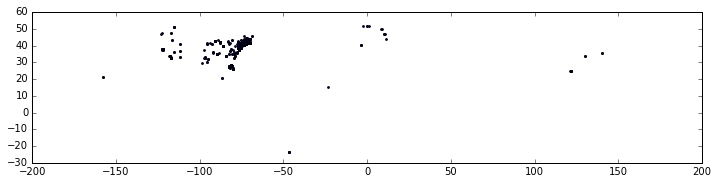

In [76]:
o_trips.plot(markersize=3, figsize=(12, 8));

Here we can see that in the raw trip file, there are trips with origins all over the globe. Our investigation area lies near the clustered points around 42°00'00.0"N 72°00'00.0"W

In [77]:
# Join the Origin trips to the filtered Hartford TAZs 
o_trip_in_taz = gpd.sjoin(o_trips, taz, how = 'inner', op = 'intersects')

In [78]:
o_trip_in_taz.shape

(26935, 88)

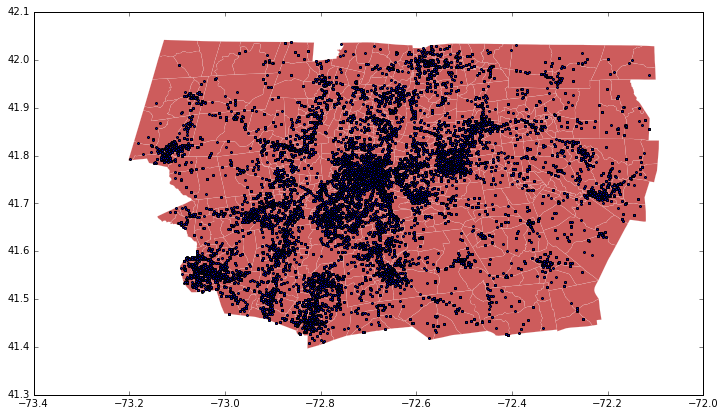

In [79]:
base1 = taz.plot(color='indianred', edgecolor='white', linewidth=.1, figsize=(12, 8))
o_trip_in_taz.plot(ax=base1, markersize=4, figsize=(12, 8));

### Determine trips with Destinations in the Study Area

Here, we use the data with origins in the study area to filter out trips with destinations outside the study area so we are finally left with trips that have both origin and destination in the study area

In [80]:
d_geometry = [Point(xy2) for xy2 in zip(o_trip_in_taz.d_lng, o_trip_in_taz.d_lat)]
d_trips = GeoDataFrame(o_trip_in_taz, crs=crs, geometry=d_geometry)
d_trips.head(2)

,hhid,segnum,week,traveldate,person_num,personid,hh_hts_status,trip_num,tripid,prepop,o_name,d_name,o_address,o_lat,o_lng,d_address,d_lat,d_lng,departure_time,arrival_time,departure_time_hhmm,arrival_time_hhmm,departure_hour,arrival_hour,reported_duration,implied_speed_mph,travelers_total,travelers_hh,travelers_nonhh,o_purpose,d_purpose,d_purpose_other,t_purpose,mode,mode_category,mode_hhauto,driver,hov_use,tollroad_use,tollroad_cost,tollroad_cost_dk,park_loc,park_pay,park_cost,park_cost_dk,taxi_cost,taxi_cost_dk,transit_access,transit_egress,transit_pay,transit_cost,transit_cost_dk,transit_system_1,transit_system_2,transit_system_3,transit_system_4,transit_line_1,transit_line_2,transit_line_3,transit_line_4,transit_transfers,gdistance,gduration,gdistance_bins,gduration_bins,hhmember1,hhmember2,hhmember3,hhmember4,hhmember5,hhmember6,hhmember7,hhmember8,hhmember9,hhmembernone,geometry,index_right,ID,AREA,TAZ,TOWN,STATE,ID_1,AREA_1,TAZ_1,TOWN_1,STATE_1,New_TAZ
0,16145362,3,10,2016-05-24,1,1614536201,1,1,161453620101,0,HOME,WORK,"1202 Middle Turnpike W, Manchester, CT 06040, USA",41.781032,-72.576455,"600 Cottage Grove Rd, Bloomfield, CT 06002, USA",41.816179,-72.729369,300,330,08:00,08:30,8,8,30,26.347373142,1,1,0,1,2,,HBW,3,1,1,,,2,,,3,,,,,,,,,,,,,,,,,,,,13.173687,19,10,10,1,0,0,,,,,,,1,POINT (-72.7293688 41.8161789),1353,1320,0.56,593,Manchester,CT,1320,0.56,593,Manchester,CT,496
3,16145362,3,10,2016-05-24,2,1614536202,1,1,161453620201,0,HOME,GYM,"1202 Middle Turnpike W, Manchester, CT 06040, USA",41.781032,-72.576455,"412 Middle Turnpike W, Manchester, CT 06040, U...",41.779989,-72.542074,975,985,19:15,19:25,19,19,10,11.043005412,1,1,0,1,11,,HBO,3,1,1,,,,,,3,,,,,,,,,,,,,,,,,,,,1.840501,4,0,0,0,1,0,,,,,,,1,POINT (-72.5420737 41.7799891),1353,1320,0.56,593,Manchester,CT,1320,0.56,593,Manchester,CT,496


In [81]:
del d_trips['index_right']
d_trips.tail()

,hhid,segnum,week,traveldate,person_num,personid,hh_hts_status,trip_num,tripid,prepop,o_name,d_name,o_address,o_lat,o_lng,d_address,d_lat,d_lng,departure_time,arrival_time,departure_time_hhmm,arrival_time_hhmm,departure_hour,arrival_hour,reported_duration,implied_speed_mph,travelers_total,travelers_hh,travelers_nonhh,o_purpose,d_purpose,d_purpose_other,t_purpose,mode,mode_category,mode_hhauto,driver,hov_use,tollroad_use,tollroad_cost,tollroad_cost_dk,park_loc,park_pay,park_cost,park_cost_dk,taxi_cost,taxi_cost_dk,transit_access,transit_egress,transit_pay,transit_cost,transit_cost_dk,transit_system_1,transit_system_2,transit_system_3,transit_system_4,transit_line_1,transit_line_2,transit_line_3,transit_line_4,transit_transfers,gdistance,gduration,gdistance_bins,gduration_bins,hhmember1,hhmember2,hhmember3,hhmember4,hhmember5,hhmember6,hhmember7,hhmember8,hhmember9,hhmembernone,geometry,ID,AREA,TAZ,TOWN,STATE,ID_1,AREA_1,TAZ_1,TOWN_1,STATE_1,New_TAZ
66087,16119351,6,8,2016-05-10,3,1611935103,1,4,161193510304,1,PARK,HOME,"Crandall's Park, Tolland, CT 06084, USA",41.862163,-72.373289,"88 Old Kent Rd N, Tolland, CT 06084, USA",41.857174,-72.392367,840,850,17:00,17:10,17,17,10,18.149,2,2,0,11,1,,HBO,3,2,1,2,,,,,1,,,,,,,,,,,,,,,,,,,,3.024834,7,0,0,1,0,1,0,,,,,,0,POINT (-72.3923666 41.8571738),1487,1.30,3065,Tolland,CT,1487,1.30,3065,Tolland,CT,1223
66088,16119351,6,8,2016-05-10,3,1611935103,1,1,161193510301,0,HOME,SCHOOL,"88 Old Kent Rd N, Tolland, CT 06084, USA",41.857174,-72.392367,"1 Eagle Hill, Tolland, CT 06084, USA",41.871790,-72.339571,210,235,06:30,06:55,6,6,25,10.4823,7,2,5,1,4,,HBSch,8,97,,,,,,,,,,,,,,,,,,,,,,,,,,,4.367617,10,0,10,0,0,1,1,,,,,,0,POINT (-72.3395714 41.87179),1487,1.30,3065,Tolland,CT,1487,1.30,3065,Tolland,CT,1223
66090,16119351,6,8,2016-05-10,4,1611935104,1,1,161193510401,1,HOME,SCHOOL,"88 Old Kent Rd N, Tolland, CT 06084, USA",41.857174,-72.392367,"1 Eagle Hill, Tolland, CT 06084, USA",41.871790,-72.339571,210,235,06:30,06:55,6,6,25,10.4823,7,2,5,1,4,,HBSch,8,97,,,,,,,,,,,,,,,,,,,,,,,,,,,4.367617,10,0,10,0,0,1,1,,,,,,0,POINT (-72.3395714 41.87179),1487,1.30,3065,Tolland,CT,1487,1.30,3065,Tolland,CT,1223
66091,16119351,6,8,2016-05-10,4,1611935104,1,3,161193510403,0,HOME,RUNNING,"88 Old Kent Rd N, Tolland, CT 06084, USA",41.857174,-72.392367,"201 Mountain Spring Rd, Tolland, CT 06084, USA",41.855348,-72.405139,675,695,14:15,14:35,14,14,20,2.80176,1,1,0,1,11,,HBO,1,4,,,,,,,,,,,,,,,,,,,,,,,,,,,0.933921,2,0,0,0,0,0,1,,,,,,1,POINT (-72.40513850000001 41.8553478),1487,1.30,3065,Tolland,CT,1487,1.30,3065,Tolland,CT,1223
66084,16119351,6,8,2016-05-10,2,1611935102,1,4,161193510204,0,BIKE,HOME,"661 Boston Tpke-Rt 44, Bolton, CT 06043, Unite...",41.732544,-72.378093,"88 Old Kent Rd N, Tolland, CT 06084, USA",41.857174,-72.392367,915,960,18:15,19:00,18,19,45,15.26,1,1,0,11,11,,NWBO,2,4,,,,,,,,,,,,,,,,,,,,,,,,,,,11.445032,21,10,20,0,1,0,0,,,,,,1,POINT (-72.3923666 41.8571738),1446,0.29,5134,Andover,CT,1446,0.29,5134,Andover,CT,1393


In [82]:
# Filter destinations so that they all fall within the local Hartford Area
d_trip_in_taz = gpd.sjoin(d_trips, taz, how = 'inner', op = 'intersects')

In [83]:
d_trip_in_taz.shape

(25410, 99)

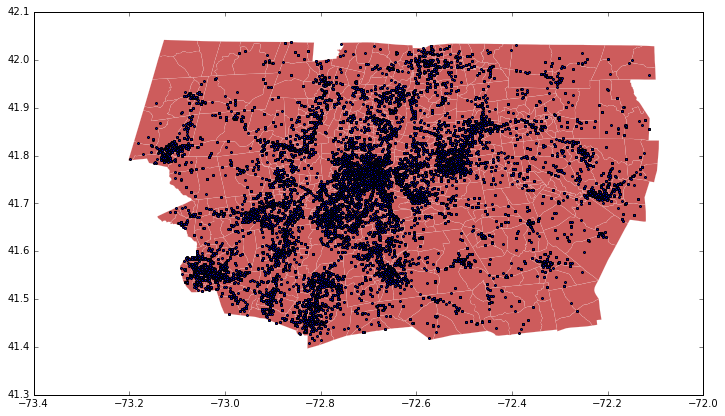

In [84]:
base2 = taz.plot(color='indianred', edgecolor='white', linewidth=.1, figsize=(12, 8))
d_trip_in_taz.plot(ax=base2, markersize=4, figsize=(12, 8));

In [85]:
d_trip_in_taz.head()

,hhid,segnum,week,traveldate,person_num,personid,hh_hts_status,trip_num,tripid,prepop,o_name,d_name,o_address,o_lat,o_lng,d_address,d_lat,d_lng,departure_time,arrival_time,departure_time_hhmm,arrival_time_hhmm,departure_hour,arrival_hour,reported_duration,implied_speed_mph,travelers_total,travelers_hh,travelers_nonhh,o_purpose,d_purpose,d_purpose_other,t_purpose,mode,mode_category,mode_hhauto,driver,hov_use,tollroad_use,tollroad_cost,tollroad_cost_dk,park_loc,park_pay,park_cost,park_cost_dk,taxi_cost,taxi_cost_dk,transit_access,transit_egress,transit_pay,transit_cost,transit_cost_dk,transit_system_1,transit_system_2,transit_system_3,transit_system_4,transit_line_1,transit_line_2,transit_line_3,transit_line_4,transit_transfers,gdistance,gduration,gdistance_bins,gduration_bins,hhmember1,hhmember2,hhmember3,hhmember4,hhmember5,hhmember6,hhmember7,hhmember8,hhmember9,hhmembernone,geometry,ID_left,AREA_left,TAZ_left,TOWN_left,STATE_left,ID_1_left,AREA_1_left,TAZ_1_left,TOWN_1_left,STATE_1_left,New_TAZ_left,index_right,ID_right,AREA_right,TAZ_right,TOWN_right,STATE_right,ID_1_right,AREA_1_right,TAZ_1_right,TOWN_1_right,STATE_1_right,New_TAZ_right
0,16145362,3,10,2016-05-24,1,1614536201,1,1,161453620101,0,HOME,WORK,"1202 Middle Turnpike W, Manchester, CT 06040, USA",41.781032,-72.576455,"600 Cottage Grove Rd, Bloomfield, CT 06002, USA",41.816179,-72.729369,300,330,08:00,08:30,8,8,30,26.347373142,1,1,0,1,2,,HBW,3,1,1,,,2,,,3,,,,,,,,,,,,,,,,,,,,13.173687,19,10,10,1,0,0,,,,,,,1,POINT (-72.7293688 41.8161789),1320,0.56,593,Manchester,CT,1320,0.56,593,Manchester,CT,496,637,604,0.38,332,Bloomfield,CT,604,0.38,332,Bloomfield,CT,255
7392,16103765,1,10,2016-05-24,1,1610376501,1,1,161037650101,0,HOME,WORK,"1 King Philip Dr, West Hartford, CT 06117, USA",41.786555,-72.740950,"701 Cottage Grove Rd, Bloomfield, CT 06002, USA",41.816414,-72.734364,285,305,07:45,08:05,7,8,20,9.344798469,1,1,0,1,97,work,HBO,3,1,1,,,2,,,3,,,,,,,,,,,,,,,,,,,,3.114933,7,0,0,1,,,,,,,,,,POINT (-72.7343645 41.8164138),601,0.28,33,West Hartford,CT,601,0.28,33,West Hartford,CT,23,637,604,0.38,332,Bloomfield,CT,604,0.38,332,Bloomfield,CT,255
10475,16237500,1,8,2016-05-11,1,1623750001,1,1,162375000101,0,HOME,DOCTOR,"35 Evergreen Ave, Hartford, CT 06105, USA",41.765173,-72.709402,"Cottage Grove Rd & West Ln, Bloomfield, CT 060...",41.817100,-72.731420,530,550,11:50,12:10,11,12,20,15.084402396,3,2,1,1,13,,HBO,97,97,,,,,,,,,,,,,,,,,,,,,,,,,,,5.028134,12,0,10,1,1,,,,,,,,0,POINT (-72.73142009999999 41.81709960000001),933,0.05,2047,Hartford,CT,933,0.05,2047,Hartford,CT,970,637,604,0.38,332,Bloomfield,CT,604,0.38,332,Bloomfield,CT,255
10477,16237500,1,8,2016-05-11,2,1623750002,1,1,162375000201,1,HOME,DOCTOR,"35 Evergreen Ave, Hartford, CT 06105, USA",41.765173,-72.709402,"Cottage Grove Rd & West Ln, Bloomfield, CT 060...",41.817100,-72.731420,530,550,11:50,12:10,11,12,20,15.084402396,3,2,1,1,97,,HBO,97,97,,,,,,,,,,,,,,,,,,,,,,,,,,,5.028134,12,0,10,1,1,,,,,,,,0,POINT (-72.73142009999999 41.81709960000001),933,0.05,2047,Hartford,CT,933,0.05,2047,Hartford,CT,970,637,604,0.38,332,Bloomfield,CT,604,0.38,332,Bloomfield,CT,255
11406,16128937,1,2,2016-03-22,3,1612893703,1,1,161289370301,0,HOME,DOCTOR'S OFFICE,"126 Clark St, Hartford, CT 06120, USA",41.788280,-72.677008,"600 Cottage Grove Rd, Bloomfield, CT 06002, USA",41.816179,-72.729369,660,680,14:00,14:20,14,14,20,14.301474936,2,2,0,1,13,,HBO,3,2,1,2,,,,,3,,,,,,,,,,,,,,,,,,,,4.767158,14,0,10,0,0,1,1,,,,,,0,POINT (-72.7293688 41.8161789),810,0.24,83,Hartford,CT,810,0.24,83,Hartford,CT,64,637,604,0.38,332,Bloomfield,CT,604,0.38,332,Bloomfield,CT,255


In [86]:
hh_veh_info = csts_data[['hhid','numvehicle']]

### Prepare the Data

Here we select the trip variables that we will use to build the model. As this model is built only on travel time skims, the most important variables are the origin and destination TAZs of each trip as well as the modal category

In [87]:
crog_trip_data = d_trip_in_taz[['hhid', 'personid', 'trip_num', 'tripid', 'o_address', 'd_address', 't_purpose', 'mode', 'mode_category', 'TAZ_1_left', 'TAZ_1_right']]

In [88]:
crog_trip_data.shape

(25410, 11)

In [89]:
#rename the columns
crog_trip_data.columns = ['hhid', 'personid', 'trip_num', 'tripid', 'o_address', 'd_address', 't_purpose', 'mode', 'mode_category', 'o_taz', 'd_taz']

In [90]:
# Here we look at the raw disaggregate modal distribution
crog_trip_data['mode'].value_counts().sort_index()

1      2379
2       159
3     20341
4       795
5        17
6        15
7        25
8       772
9       735
11       13
12       36
13        1
14        1
17        2
97      119
Name: mode, dtype: int64

In [91]:
crog_trip_data['mode_category'].value_counts().sort_index()

1     13505
2      4428
3      3203
4      2538
5        32
6       773
97      931
Name: mode_category, dtype: int64

#### Creating modal categories
Before Processing and joining the skim data, the modal categories will be grouped into 4 aggregate categories 

[1 - SOV,

2 - HOV(all types),

3 - Transit,

4 - Walk & Bike]

Within this, it is assumed that taxi/rideshare trips perform like HOV and those limited respondents (32 in total) who reported this will be included in the HOV category

Other modes (vanpool, school bus, shuttle, ferry/boat, airplane, other) will be dropped from the analysis.

In [92]:
crog_trip_data['mode_cat_new'] = crog_trip_data['mode_category']

In [93]:
crog_trip_data['mode_cat_new'].replace([2,3,5], 2, inplace=True)

In [94]:
crog_trip_data['mode_cat_new'].replace([6], 3, inplace=True)

In [95]:
crog_trip_data = crog_trip_data[crog_trip_data['mode_cat_new'] != 97]

In [96]:
crog_trip_data['mode_cat_new'].value_counts().sort_index()

1    13505
2     7663
3      773
4     2538
Name: mode_cat_new, dtype: int64

Here we estimate the travel times for active modes like walk and bike. This is done by using the SOV skim distances (assumably road network based) and using average speeds for the active modes to calculate travel time.

The average speeds used in this estimation are: <br> **3.5 miles/hour** (0.05833 mi/min) for walking <br>**7.5 miles/hour** (0.125 mi/min) for biking.

Since the SOV Skim tables are missing intra-zonal travel distance, we have calculated an average time factor for both walking and biking that is multiplied by the intra-zone SOV time to determine a reasonable estimate for walking and biking times within a zone

In [97]:
sov['walk_time'] = sov['sov_distance']/0.05833
sov['bike_time'] = sov['sov_distance']/0.125

In [98]:
# Here we create the factor that will be multiplied by the know SOV time to estimate a walk/bike time for the missing intra-zonal pairs
avg_walk_sov_factor = (sov['walk_time']/sov['sov_time']).mean()
avg_bike_sov_factor = (sov['bike_time']/sov['sov_time']).mean()

In [99]:
intra_zone_walk = sov[sov['walk_time'].isnull()]['sov_time']*avg_walk_sov_factor
intra_zone_bike = sov[sov['bike_time'].isnull()]['sov_time']*avg_bike_sov_factor

In [100]:
sov['walk_time'] = sov['walk_time'].fillna(intra_zone_walk)
sov['bike_time'] = sov['bike_time'].fillna(intra_zone_bike)

### Merge CSTS Trip Data with Travel Time Skims

In [101]:
# Merge SOV and Active Data
crog_trip_data_merged = pd.merge(crog_trip_data, sov, left_on=['o_taz', 'd_taz'], right_on=['origin', 'destination'], how='left')

In [102]:
# Merge HOV Data
crog_trip_data_merged = pd.merge(crog_trip_data_merged, hov, left_on=['o_taz', 'd_taz'], right_on=['origin', 'destination'], how='left')

In [103]:
# Merge Transit Data
crog_trip_data_merged = pd.merge(crog_trip_data_merged, wbwb, left_on=['o_taz', 'd_taz'], right_on=['origin', 'destination'], how='left')

In [104]:
final_mode_data = crog_trip_data_merged[['hhid', 'personid', 'tripid', 't_purpose', 'mode', 'mode_category', 'mode_cat_new', 'o_taz', 'd_taz', 'sov_time', 'walk_time', 'bike_time', 'hov_time', 'generalized_cost', 'fare', 'ivtt', 'total_transit_time']]

In [105]:
# Drop Transit Trips That Are not "Available" Based on the skim data
final_mode_data = final_mode_data.drop(final_mode_data[((final_mode_data['mode_cat_new']==3) & ~pd.notnull(final_mode_data['total_transit_time']))].index)

In [106]:
final_mode_data['o_taz'].value_counts().shape

(1562L,)

In [107]:
final_mode_data['d_taz'].value_counts().shape

(1562L,)

### Need to Prepare the Availability information for each mode

In [108]:
hh_veh_info[:5]

,hhid,numvehicle
index_left,,
0,16100054,2
1,16100093,2
2,16100095,3
3,16100104,2
4,16100112,1


In [109]:
final_mode_data = pd.merge(final_mode_data, hh_veh_info, left_on='hhid', right_on='hhid', how='left')

In [110]:
#create availability variable for SOV mode (accounting for individuals that reported using an "other" car)
final_mode_data['sov_av'] = np.where((final_mode_data['numvehicle']>0) | (final_mode_data['mode']==4), 1, 0)

#create availability variable for HOV mode (accounting for individuals that reported using an "other" car rideashare or a taxi cab)
final_mode_data['hov_av'] = np.where((final_mode_data['numvehicle']>0) | (final_mode_data['mode']==4) | (final_mode_data['mode']==5) | (final_mode_data['mode']==6), 1, 0)

#create availability variable for Transit mode
final_mode_data['transit_av'] = np.where(pd.notnull(final_mode_data['total_transit_time']), 1, 0)

#create availability variable for Active mode
final_mode_data['active_av'] = 1

In [111]:
final_mode_data.loc[:, 'sov_av_check'] = np.where((final_mode_data['sov_av']==0) & (final_mode_data['mode_cat_new']==1), np.nan,0)
final_mode_data.loc[:, 'hov_av_check'] = np.where((final_mode_data['hov_av']==0) & (final_mode_data['mode_cat_new']==2), np.nan,0)
final_mode_data.loc[:, 'transit_av_check'] = np.where((final_mode_data['transit_av']==0) & (final_mode_data['mode_cat_new']==3), np.nan,0)
final_mode_data.loc[:, 'active_av_check'] = np.where((final_mode_data['active_av']==0) & (final_mode_data['mode_cat_new']==4), np.nan,0)

In [112]:
final_mode_data[final_mode_data['sov_av_check'].isnull()].shape

(0, 26)

In [113]:
final_mode_data[final_mode_data['hov_av_check'].isnull()].shape

(0, 26)

In [114]:
final_mode_data[final_mode_data['transit_av_check'].isnull()].shape

(0, 26)

In [115]:
# rearrange columns for ease in data format conversion
final_mode_data1 = final_mode_data[['hhid', 'personid', 'tripid', 't_purpose', 'mode', 'mode_category', 'o_taz', 'd_taz', 'numvehicle', 'mode_cat_new', 'sov_time', 'hov_time', 'walk_time', 'bike_time', 'total_transit_time', 'sov_av', 'hov_av', 'transit_av', 'active_av']]

In [116]:
# To bring the travel times of walking anf biking together, we assume and average time that will represent the "active" travel time
final_mode_data1['active_time'] = (final_mode_data1['walk_time'] + final_mode_data1['bike_time'])/2

In [117]:
sov[sov['sov_time'].isnull()]

,origin,destination,sov_time,sov_distance,walk_time,bike_time
3207682,2,797,NaN,NaN,NaN,NaN
3207683,797,2,NaN,NaN,NaN,NaN


In [118]:
final_mode_data1 = final_mode_data1[~final_mode_data1['sov_time'].isnull()]

In [119]:
final_mode_data1.shape

(24061, 20)

### Dealing with Pylogit Issues

After some tests with the full data set of about 24,000 trips, it was determined that pylogit could not complete the model estimation due to a memory limit error. To over come this, a random sample of 4812 trips (20% of the total) will be used to estimate the model.

In [120]:
sample = final_mode_data1.sample(frac=.2, random_state=18)

In [121]:
sample.shape

(4812, 20)

In [122]:
sample['mode_cat_new'].value_counts()

1    2749
2    1486
4     484
3      93
Name: mode_cat_new, dtype: int64

### Need to Convert the data to long format

In [123]:
# Here we create the list of individual specific variables and prep data for conversion to long format
ind_variables = sample.columns.tolist()[:9]

alt_varying_variables = {u'travel_time': dict([(1, 'sov_time'),
                                               (2, 'hov_time'),
                                               (3, 'total_transit_time'),
                                               (4, 'active_time')])}

availability_variables = {1: 'sov_av',
                          2: 'hov_av', 
                          3: 'transit_av',
                          4: 'active_av'}

custom_alt_id = "mode_id"

obs_id_column = "custom_id"
sample[obs_id_column] = np.arange(sample.shape[0],
                                            dtype=int) + 1

choice_column = "mode_cat_new"

In [124]:
# Here we convery the wide dataset to a long dataset
final_long = pl.convert_wide_to_long(sample, 
                                    ind_variables, 
                                    alt_varying_variables, 
                                    availability_variables, 
                                    obs_id_column, 
                                    choice_column,
                                    new_alt_id_name=custom_alt_id)

final_long.head(30).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
custom_id,1,1,1,1,2,2,2,3,3,3,4,4,4,4,5,5,5,6,6,6,6,7,7,7,8,8,8,9,9,9
mode_id,1,2,3,4,1,2,4,1,2,4,1,2,3,4,1,2,4,1,2,3,4,1,2,4,1,2,4,1,2,4
mode_cat_new,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0
hhid,16204051,16204051,16204051,16204051,16103808,16103808,16103808,16174756,16174756,16174756,16177889,16177889,16177889,16177889,16142947,16142947,16142947,16167582,16167582,16167582,16167582,16227631,16227631,16227631,16136865,16136865,16136865,16217174,16217174,16217174
personid,1620405103,1620405103,1620405103,1620405103,1610380801,1610380801,1610380801,1617475602,1617475602,1617475602,1617788901,1617788901,1617788901,1617788901,1614294701,1614294701,1614294701,1616758201,1616758201,1616758201,1616758201,1622763101,1622763101,1622763101,1613686502,1613686502,1613686502,1621717402,1621717402,1621717402
tripid,162040510301,162040510301,162040510301,162040510301,161038080105,161038080105,161038080105,161747560205,161747560205,161747560205,161778890104,161778890104,161778890104,161778890104,161429470106,161429470106,161429470106,161675820101,161675820101,161675820101,161675820101,162276310108,162276310108,162276310108,161368650202,161368650202,161368650202,162171740204,162171740204,162171740204
t_purpose,HBW,HBW,HBW,HBW,NWBO,NWBO,NWBO,HBO,HBO,HBO,NWBO,NWBO,NWBO,NWBO,HBO,HBO,HBO,HBShp,HBShp,HBShp,HBShp,HBShp,HBShp,HBShp,NWBO,NWBO,NWBO,HBW,HBW,HBW
mode,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3
mode_category,1,1,1,1,1,1,1,1,1,1,3,3,3,3,4,4,4,1,1,1,1,1,1,1,3,3,3,1,1,1
o_taz,532,532,532,532,8024,8024,8024,715,715,715,2157,2157,2157,2157,595,595,595,36,36,36,36,408,408,408,793,793,793,242,242,242


#### Here we Set Up the Choice Model Formulation

Without Further Information at the TAZ level (besides the travel time skims) the model formulation is limited. The utility formulation is presented below:

$$ U_{sov} = B_{TTsov}*TravelTime_{sov} $$

$$ U_{hov} =  ASC_{hov} + B_{TThov}*TravelTime_{hov}$$

$$ U_{transit} = ASC_{transit} + B_{TTtransit}*TravelTime_{transit} $$

$$ U_{active} = ASC_{active} + B_{TTactive}*TravelTime_{active} $$

In [125]:
basic_specification = OrderedDict()
basic_names = OrderedDict()

basic_specification["intercept"] = [2, 3, 4]
basic_names["intercept"] = ['ASC HOV',
                            'ASC Transit',
                            'ASC Active']

basic_specification["travel_time"] = [1, 2, 3, 4]
basic_names["travel_time"] = ['Travel Time, units:min (SOV)',
                              'Travel Time, units:min (HOV)',
                              'Travel Time, units:min (Transit)',
                              'Travel Time, units:min (Active)']

In [126]:
# Estimate the multinomial logit model (MNL)
mode_choice_mnl = pl.create_choice_model(data=final_long,
                                        alt_id_col=custom_alt_id,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_column,
                                        specification=basic_specification,
                                        model_type="MNL",
                                        names=basic_names)

# Specify the initial values and method for the optimization.
mode_choice_mnl.fit_mle(np.zeros(7))

# Look at the estimation results
mode_choice_mnl.get_statsmodels_summary()

Log-likelihood at zero: -5,551.9820
Initial Log-likelihood: -5,551.9820
Estimation Time: 0.09 seconds.
Final log-likelihood: -3,928.3638


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                mode_cat_new   No. Observations:                4,812
Model:             Multinomial Logit Model   Df Residuals:                    4,805
Method:                                MLE   Df Model:                            7
Date:                     Tue, 12 Dec 2017   Pseudo R-squ.:                   0.292
Time:                             14:37:26   Pseudo R-bar-squ.:               0.291
converged:                            True   Log-Likelihood:             -3,928.364
                                             LL-Null:                    -5,551.982
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
ASC HOV                             -0.3262      0.049     -6.707      0.000      -0.422      -0.231
ASC Transit                         -1.9232      0.260     -7.411      0.000      -2.432      -1.415
ASC Active                           0.1981      0.095      2.085      0.037       0.012       0.384
Travel Time, units:min (SOV)        -0.0390      0.033     -1.193      0.233      -0.103       0.025
Travel Time, units:min (HOV)        -0.0705      0.033     -2.124      0.034      -0.136      -0.005
Travel Time, units:min (Transit)    -0.0234      0.010     -2.408      0.016      -0.042      -0.004
Travel Time, units:min (Active)     -0.0950      0.008    -12.540      0.000      -0.110      -0.080
====================================================================================================
"""

### Estimating modal probabilities

In [127]:
# Save the coefficients from the logistic regression for use in calculating probabilities
coeffs = mode_choice_mnl.params

In [130]:
# Rearrange the columns for easy in mode probability determination & Create Active time
travel_time_mode = travel_time_merged2[['origin', 'destination', 'TRIP_PRODUCTIONS_x', 'TRIP_ATTRACTIONS_y', 'detterence_func', 'denominator_y', 'TI_PA', 'TI_OD',  'sov_time_x', 'walk_time', 'bike_time', 'hov_time', 'total_transit_time']]             
travel_time_mode['active_time'] = (travel_time_mode['walk_time'] + travel_time_mode['bike_time'])/2

In [131]:
# Fill Zones with no Transit (transit travel times of NaN) with a large number ex.1500 for use in mode split estimation.
travel_time_mode['total_transit_time'].fillna(1500, inplace=True)

In [132]:
coeffs

ASC HOV                            -0.326186
ASC Transit                        -1.923157
ASC Active                          0.198092
Travel Time, units:min (SOV)       -0.039024
Travel Time, units:min (HOV)       -0.070531
Travel Time, units:min (Transit)   -0.023405
Travel Time, units:min (Active)    -0.094986
Name: parameters, dtype: float64

### Calculate the probability splits

To go from the log-odds output derived from the logit model, we first calculate the log-odds by plugging into the logistic-regression equation for each mode. Then, we take e^(log-odds) to determine the odds. Finally, the probability is calcuated by taking odds/sum(odds) for each mode in each zone.

$$ P_i=\dfrac{exp(X_i\beta)}{\sum_Jexp(X_j\beta)} $$

In [133]:
# Calculate the odds for SOV
travel_time_mode['sov_odds'] = np.exp(travel_time_mode['sov_time_x']*coeffs[3])

In [134]:
# Calculate the odds for HOV
travel_time_mode['hov_odds'] = np.exp((coeffs[0]+travel_time_mode['hov_time']*coeffs[4]))

In [135]:
# Calculate the odds for Transit
travel_time_mode['transit_odds'] = np.exp((coeffs[1]+travel_time_mode['total_transit_time']*coeffs[5]))

In [136]:
# Calculate the odds for Active
travel_time_mode['active_odds'] = np.exp((coeffs[2]+travel_time_mode['active_time']*coeffs[6]))

In [137]:
# Calculate the Modal Probabilities
travel_time_mode['sov_prob'] = (travel_time_mode['sov_odds'] / (travel_time_mode['sov_odds'] + travel_time_mode['hov_odds'] + travel_time_mode['transit_odds'] + travel_time_mode['active_odds']))
travel_time_mode['hov_prob'] = (travel_time_mode['hov_odds'] / (travel_time_mode['sov_odds'] + travel_time_mode['hov_odds'] + travel_time_mode['transit_odds'] + travel_time_mode['active_odds']))
travel_time_mode['transit_prob'] = (travel_time_mode['transit_odds'] / (travel_time_mode['sov_odds'] + travel_time_mode['hov_odds'] + travel_time_mode['transit_odds'] + travel_time_mode['active_odds']))
travel_time_mode['active_prob'] = (travel_time_mode['active_odds'] / (travel_time_mode['sov_odds'] + travel_time_mode['hov_odds'] + travel_time_mode['transit_odds'] + travel_time_mode['active_odds']))

In [138]:
#Check to see if total Probability sums to 1
(travel_time_mode['sov_prob'] + travel_time_mode['hov_prob'] + travel_time_mode['transit_prob'] + travel_time_mode['active_prob']).unique()

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.])

### Finding the Trip Interchanges by Mode

Here, the modal probabilities are multiplied by the Origin-Destination Trip Interchange numbers to determine the number of trips made by each mode for all zone pairs.

In [139]:
travel_time_mode['TI_OD_SOV'] = travel_time_mode['TI_OD'] * travel_time_mode['sov_prob']
travel_time_mode['TI_OD_HOV'] = travel_time_mode['TI_OD'] * travel_time_mode['hov_prob']
travel_time_mode['TI_OD_Transit'] = travel_time_mode['TI_OD'] * travel_time_mode['transit_prob']
travel_time_mode['TI_OD_Active'] = travel_time_mode['TI_OD'] * travel_time_mode['active_prob']

In [140]:
final_data = travel_time_mode[['origin', 'destination', 'TI_PA', 'TI_OD', 'TI_OD_SOV', 'TI_OD_HOV', 'TI_OD_Transit', 'TI_OD_Active']]

In [141]:
final_data.head(50)

,origin,destination,TI_PA,TI_OD,TI_OD_SOV,TI_OD_HOV,TI_OD_Transit,TI_OD_Active
0,2,2,9.822263,9.822263,3.774289,2.689683,3.172981e-16,3.358290e+00
1,2,9,8.820276,5.048578,3.322210,1.722231,4.142236e-16,4.136805e-03
2,2,10,0.201501,2.094540,1.344942,0.743267,1.549197e-16,6.331466e-03
3,2,11,4.690710,5.513248,3.484447,1.996693,3.837486e-16,3.210808e-02
4,2,12,1.209537,3.501896,2.235285,1.252155,2.531911e-16,1.445635e-02
5,2,13,0.458231,3.168544,2.260199,0.908342,3.862733e-16,3.054909e-06
6,2,14,2.805698,3.766154,2.516098,1.249239,3.309437e-16,8.173405e-04
7,2,15,1.117511,4.527230,3.051882,1.474285,4.152782e-16,1.063033e-03
8,2,16,0.347829,3.319011,2.343814,0.975164,3.837324e-16,3.190116e-05
9,2,17,3.238573,3.605561,2.596152,1.009405,4.622465e-16,3.612360e-06


### Validity Checks

In [142]:
# Check to see if the sum of modal trips adds up to total trips
final_data['TI_OD'].sum(),(final_data['TI_OD_SOV'].sum() + final_data['TI_OD_HOV'].sum() + final_data['TI_OD_Transit'].sum() + final_data['TI_OD_Active'].sum())

(5060012.6529613556, 5060012.6529613603)

The total number of O-D trips predicted is very close to that predicted by the sum of each individual mode's prediction. This is what we expected to see.

### Logic Checks

In this section, we explore some of the findings (like what zone has the highest Active users OR Transit users) and comparing this with the TAZ location to see if this makes sense at a high level.

In [143]:
# Top Active Zone Pair
final_data[final_data['TI_OD_Active'] == final_data['TI_OD_Active'].max()]

,origin,destination,TI_PA,TI_OD,TI_OD_SOV,TI_OD_HOV,TI_OD_Transit,TI_OD_Active
2854381,8410,8410,9025.843173,9025.843173,3987.796509,2790.375394,3.429219e-13,2247.67127


In [144]:
taz[taz['TAZ']==8410]

,ID,AREA,TAZ,TOWN,STATE,ID_1,AREA_1,TAZ_1,TOWN_1,STATE_1,New_TAZ,geometry
index_right,,,,,,,,,,,,
1560,1520,3.13,8410,Mansfield,CT,1520,3.13,8410,Mansfield,CT,1738,"POLYGON ((-72.25508099999999 41.818705, -72.25..."


In [167]:
(taz[taz['TAZ']==8410]['geometry'].centroid.y.values[0], taz[taz['TAZ']==8410]['geometry'].centroid.x.values[0])

(41.811292756365759, -72.253515846780672)

According to our modeled output, the top 'active' zone in the target region is that encompassing the University of Connecticut. This seems to make sense, as there are a substantial portion of intra-zonal trips in this area and having a sizeable portion of these be walk & bike based is logical.

In [145]:
# Top Transit Zone Pair
final_data[final_data['TI_OD_Transit'] == final_data['TI_OD_Transit'].max()]

,origin,destination,TI_PA,TI_OD,TI_OD_SOV,TI_OD_HOV,TI_OD_Transit,TI_OD_Active
2813706,8386,8391,939.157498,745.108624,317.657372,218.180241,28.656728,180.614284


In [168]:
(taz[taz['TAZ']==8386]['geometry'].centroid.y.values[0], taz[taz['TAZ']==8386]['geometry'].centroid.x.values[0])

(41.720456522611023, -72.234670331031737)

In [169]:
(taz[taz['TAZ']==8391]['geometry'].centroid.y.values[0], taz[taz['TAZ']==8391]['geometry'].centroid.x.values[0])

(41.713121516489664, -72.214142734279847)

The top transit trip zone interchange is in Windam in the Downtown Willimantic area between two adjacent zones. In reality, this probably does not make much sense. However, it is important to note that the modal split is determined by travel time skims and there are a substantial portion of missing skim values in the original data source. While this zone pair may have substantial transit use, in reality is most likely not the highest transit zone pair.

## Final Results & Discussion

In [330]:
def get_taz_info(taz_num):
    """Use this function to find the town name and lat/lng centriod of a TAZ given its number."""
    town = taz[taz['TAZ']==taz_num]['TOWN'].values[0]
    (lat, lng) = (taz[taz['TAZ']==taz_num]['geometry'].centroid.y.values[0], taz[taz['TAZ']==taz_num]['geometry'].centroid.x.values[0])
    return town, lat, lng

In [283]:
# Mean SOV Trip Interchanges in Origin Destination Format and the Standard Deviation
print ('The average daily SOV trip interchange value for all zones is %r, and the standard deviation is %r') % (final_data['TI_OD_SOV'].mean().round(2), final_data['TI_OD_SOV'].std().round(2))
print ('The maximum daily SOV trip interchange value is %r, and falls between zones %r and %r') % (final_data['TI_OD_SOV'].max(), final_data[final_data['TI_OD_SOV'] == final_data['TI_OD_SOV'].max()]['origin'].values[0], final_data[final_data['TI_OD_SOV'] == final_data['TI_OD_SOV'].max()]['destination'].values[0])                   

The average daily SOV trip interchange value for all zones is 1.21, and the standard deviation is 5.21
The maximum daily SOV trip interchange value is 3987.7965089913378, and falls between zones 8410.0 and 8410.0


In [282]:
# Mean HOV Trip Interchanges in Origin Destination Format and the Standard Deviation
print ('The average HOV trip interchange value for all zones is %r, and the standard deviation is %r') % (final_data['TI_OD_HOV'].mean().round(2), final_data['TI_OD_HOV'].std().round(2))
print ('The maximum daily HOV trip interchange value is %r, and falls between zones %r and %r') % (final_data['TI_OD_HOV'].max(), final_data[final_data['TI_OD_HOV'] == final_data['TI_OD_HOV'].max()]['origin'].values[0], final_data[final_data['TI_OD_HOV'] == final_data['TI_OD_HOV'].max()]['destination'].values[0])                   

The average HOV trip interchange value for all zones is 0.51000000000000001, and the standard deviation is 3.0099999999999998
The maximum daily HOV trip interchange value is 2790.3753941999375, and falls between zones 8410.0 and 8410.0


In [284]:
# Mean Transit Trip Interchanges in Origin Destination Format and the Standard Deviation
print ('The average daily transit trip interchange value for all zones is %r, and the standard deviation is %r') % (final_data['TI_OD_Transit'].mean().round(2), final_data['TI_OD_Transit'].std().round(2))
print ('The maximum daily transit trip interchange value is %r, and falls between zones %r and %r') % (final_data['TI_OD_Transit'].max(), final_data[final_data['TI_OD_Transit'] == final_data['TI_OD_Transit'].max()]['origin'].values[0], final_data[final_data['TI_OD_Transit'] == final_data['TI_OD_Transit'].max()]['destination'].values[0])                   

The average daily transit trip interchange value for all zones is 0.02, and the standard deviation is 0.12
The maximum daily transit trip interchange value is 28.656727580158677, and falls between zones 8386.0 and 8391.0


In [285]:
# Mean Active Trip Interchanges in Origin Destination Format and the Standard Deviation
print ('The average daily active trip interchange value for all zones is %r, and the standard deviation is %r') % (final_data['TI_OD_Active'].mean().round(2), final_data['TI_OD_Active'].std().round(2))
print ('The maximum daily active trip interchange value is %r, and falls between zones %r and %r') % (final_data['TI_OD_Active'].max(), final_data[final_data['TI_OD_Active'] == final_data['TI_OD_Active'].max()]['origin'].values[0], final_data[final_data['TI_OD_Active'] == final_data['TI_OD_Active'].max()]['destination'].values[0])                   

The average daily active trip interchange value for all zones is 0.029999999999999999, and the standard deviation is 1.96
The maximum daily active trip interchange value is 2247.6712699103114, and falls between zones 8410.0 and 8410.0


In [305]:
# Top 15 Most Intense Zones based on overall O-D Trip Interchange numbers
final_data.groupby('origin').sum().sort_values(['TI_OD'], ascending=False).head(15)

,TI_PA,TI_OD,TI_OD_SOV,TI_OD_HOV,TI_OD_Transit,TI_OD_Active
origin,,,,,,
8410.0,40193.628728,44267.905783,29179.079373,12583.767711,6.111062e-12,2505.058700
178.0,549.625610,43006.190803,29159.251407,12601.501450,8.635520e+02,381.885955
1028.0,11963.333742,30881.995449,20876.305622,8794.549171,3.360400e+02,875.100682
1044.0,9731.830086,25673.867232,17884.356327,7489.964197,3.346069e-12,299.546708
5057.0,0.000000,25403.542133,17990.394874,7030.490743,3.019128e+02,80.743716
2105.0,0.000000,22394.239583,14990.562318,6450.378421,6.010720e+02,352.226818
375.0,485.271853,22222.602958,15114.666741,6466.345936,4.751795e+02,166.410803
8093.0,2363.668154,22195.477297,15581.607989,6453.145706,2.990562e-12,160.723602
2103.0,0.000000,20583.848373,13809.754953,5893.826739,5.347261e+02,345.540558


In [334]:
get_taz_info(1028)

(u'Bristol', 41.658508931997495, -72.912427876512027)

The Top 3 most intense zones all represent areas of substantial trip making, the top being the University of Connecticut, the second being Pratt and Whitney's location in East Hartford, and the third being ESPN's Headquarters in Bristol

In [316]:
# Top 15 Transit Zones based on Transit O-D Trip Interchange numbers
final_data.groupby('origin').sum().sort_values(['TI_OD_Transit'], ascending=False).head(15)

,TI_PA,TI_OD,TI_OD_SOV,TI_OD_HOV,TI_OD_Transit,TI_OD_Active
origin,,,,,,
178.0,549.625610,43006.190803,29159.251407,12601.501450,863.551990,381.885955
2105.0,0.000000,22394.239583,14990.562318,6450.378421,601.072027,352.226818
2103.0,0.000000,20583.848373,13809.754953,5893.826739,534.726123,345.540558
375.0,485.271853,22222.602958,15114.666741,6466.345936,475.179476,166.410803
104.0,3484.756223,17389.016025,11485.765606,4914.929443,453.008799,535.312177
2007.0,331.516923,15892.817776,10637.450156,4557.881409,414.026566,283.459645
2010.0,136.724050,15938.512874,10698.254776,4559.388165,406.559278,274.310655
2085.0,7.348951,14883.938426,10000.204938,4176.195716,372.062529,335.475242
1028.0,11963.333742,30881.995449,20876.305622,8794.549171,336.039974,875.100682


In [331]:
get_taz_info(178)

(u'East Hartford', 41.753033399412701, -72.623466692026199)

One interesting thing to note about the top 15 transit zones is that the vast majority of them are in Hartford (2000's numbers) and East Hartford (100-300's). The remaining zones fall in areas like Farmington and Bristol.

## Limitations

The final modeled output presented above should be taken with a grain of salt. Much of this modeling endeavor was built merging a wealth of data from the CSTS with limited land use and system level information that was generously provided by both CRCOG and Dr. Karthik Konduri. Presented below is a discussion of some of the assumptions that were made and their associated limitations.

At the ***Trip Generation level***, the linear regression model for estimating trip productions had a lean specification. This was controlled by the variables available in the land use file, as fewer variables (compared to Household Travel Survey data) were available in the land use file. Moreover, not all of the land use file's variables were significant. The same is true for trip attractions model, where we assumed that trip attractions are functions of employment only, as this was the only viable variable ready to use in the model. Linear regression model was fitted for simplicity and ease of understanding. Other model formulations may be utilized for estimating trip generation.

At the ***Trip Distribution level***, the use of singly constrainted gravity model is fairly reasonable. As a whole, the validity of trip distribution step depends on the validity of trip generations and selection of proper model. Due to resticstion in zonal level data, trip attraction model was very naive. If there were better data on the attraction side, a doubly constraint gravity model could have been used instead. The exponential deterrence function may or may not be the accurate function to be used. The model could be reran for a few different deterrence functions. The assumption of $\beta$ coefficient can also be revisited. Moreover the attractiveness factor ($k_{ij}$) could be calculated if data for check is available. 

At the ***Mode Choice level***, the most influential assumption was that users' choice of mode depends solely on travel time. This was done because available aggregate demographic data on zonal level factors was missing. This prevented us from incorporating typical mode choice variables like presence of children and specific vehicle ownership information. Another limiting factor here was that there is a substantial disconnect with the transit skim times used and the actual available service. Using Google’s GTFS feeds for reference, there are a substantial amount of zones that do have service and thus should also have skim traces but are not represented in the available data. Future work to incorporate this information would likely improve the representation of transit in the model. Also, the assumption to use an average active travel time also likely inflates that active mode share slightly as there is no distinction between the two. Effectively, this makes the higher magnitude walking trips seem shorter and thus more attractive. 